# Project 3: Classification of Subreddits

## Problem Statement

People seek advice from each other all the time, especially on social media platforms like **Reddit** (where they can maintain their anonymity). Given a post from a user seeking advice on a subreddit, is it possible to **categorize the post into different categories (by employing different Machine Learning techniques)**? If yes, **how accurately can this advice request categorization be done?**

## Executive Summary

According to this [page](https://foundationinc.co/lab/reddit-statistics/), Reddit is a rapidly growing social media sharing platform with a 330 million active users count as of 2018, and a 30% increase in the active users count in 2019. People come to Reddit for all different types of reasons, ranging from just browsing the latest [meme content](https://www.reddit.com/r/funny/) or news to connecting with people of similar interests, sharing their experiences, etc. **One important reason for people to visit Reddit is to seek and give advice (on a broad range of topics), or just about their situations/experiences in life in general.**

Reddit is trying to introduce **a new feature to automatically suggest categories/subreddits to users for posting their requests for advice**, based on the text of the user's post seeking the advice. The feature is being introduced to better guide people seeking advice to the appropriate subreddits, so that their requests can be answered in a better and effective manner by the dedicated subreddit community. To introduce this feature, Reddit is trying to understand whether or not it is possible to automatically categorize the advice posts based on their text. And if it is indeed possible to categorize such posts, how effectively/accurately can this done?

To answer this question and give Reddit a brief sample of the possibilities of machine learning, in this project, I seek to apply different data classification techniques to classify textual posts from **two subreddits - [r/relationship_advice](https://www.reddit.com/r/relationship_advice/) (dedicated for people seeking advice on their personal relationships) and [r/legaladvice](https://www.reddit.com/r/legaladvice/) (dedicated for people seeking semi-professional/professional advice on legal issues)**.

For ease of organization and understanding, the project has been **divided into 2 separate Jupyter notebooks**. The first notebook focuses on data gathering via web-scraping from the Reddit API. In order to do the classification modelling, about a 1000 posts were scraped from each of the two subreddits (sorted by newest at the time of scraping). The second notebook then focuses on data cleaning, EDA and different techniques of classification modelling.

In order to classify the posts from the two subreddits, I employ different methods of classification, such as **Logistic Regression, K-Nearest Neighbors classifier, Naive Bayes classifier and Random Forests**. Each of the models and their hyperparameters are optimized by passing them through **Cross-Validated Grid Searching (GridSearchCV)**. As I am dealing with textual data, I also employ different **NLP techniques** to convert text into machine-understandable forms of data, such as **Count Vectorization and TF-IDF Vectorization**. Each of the classification models built are assessed for generalizability using the **Accuracy metric**, with the final selected model being evaluated on further metrics such as **Sensitivity (True Positive Rate), Specificity (True Negative Rate) and ROC AUC**.

### Contents:
- Jupyter Notebook 1 - ***1_data_gathering_from_reddit_api.ipynb***
    - Data Gathering
        - Web Scraping via Reddit API
        - Verifying the Scraped Data
- Jupyter Notebook 2 - ***2_pre_processing_classification_evaluation.ipynb***
    - [Data Importing and Cleaning](#Data-Importing-and-Cleaning)
        - [Data Importing](#Data-Importing)
        - [Data Cleaning and Pre-processing](#Data-Cleaning-and-Pre-processing)
    - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
        - [Visualizing Differences in User Activity Levels](#Visualizing-Differences-in-User-Activity-Levels)
        - [Visualizing Differences in Posts](#Visualizing-Differences-in-Posts)
    - [Classification Modelling](#Classification-Modelling)
        - [Model Preparation](#Model-Preparation)
        - [Classification Metrics](#Classification-Metrics)
        - [Vectorization of Words (CountVectorizer & TfidfVectorizer with LogisticRegression)](#Vectorization-of-Words-(CountVectorizer-&-TfidfVectorizer-with-LogisticRegression))
        - [TfidfVectorizer with KNeighborsClassifier](#TfidfVectorizer-with-KNeighborsClassifier)
        - [TfidfVectorizer with MultinomialNB](#TfidfVectorizer-with-MultinomialNB)
        - [TfidfVectorizer with RandomForestClassifier](#TfidfVectorizer-with-RandomForestClassifier)
    - [Final Classification Modelling and Evaluation](#Final-Classification-Modelling-and-Evaluation)
        - [ROC Curve](#ROC-Curve)
        - [Feature Importance](#Feature-Importance)
        - [Evaluation Metrics Summary](#Evaluation-Metrics-Summary)
        - [Analysis of Misclassified Posts](#Analysis-of-Misclassified-Posts)
    - [Conclusions and Recommendations](#Conclusions-and-Recommendations)

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns
import datetime

from bs4 import BeautifulSoup
import contractions
from nltk.tokenize import RegexpTokenizer
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

Documentation for ***contractions* library** can be found [here](https://github.com/kootenpv/contractions). Documentation for ***wordcloud* library** can be found [here](http://amueller.github.io/word_cloud/).

## Data Importing and Cleaning

### Data Importing

In [2]:
# Reading the CSV relationshipadvice_raw_posts.csv.

relad_raw = pd.read_csv("../data/relationshipadvice_raw_posts.csv")

In [3]:
relad_raw.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video
0,NaN,relationship_advice,We been dating for almost 2 years now and he s...,t2_54fr010z,False,NaN,0,False,Should I be upset if my boyfriend doesn’t reme...,[],...,NaN,/r/relationship_advice/comments/ggjd4u/should_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3026114,1.589044e+09,0,NaN,False
1,NaN,relationship_advice,I'll split my situation into parts so its easi...,t2_k6tv9,False,NaN,0,False,What advice could you all give me ?,[],...,NaN,/r/relationship_advice/comments/ggjc7u/what_ad...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3026114,1.589044e+09,0,NaN,False
2,NaN,relationship_advice,So this is going to be long. I'm not sure if t...,t2_1aasy0iv,False,NaN,0,False,Confused. Posting here for advice on my relati...,[],...,NaN,/r/relationship_advice/comments/ggjc0o/confuse...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3026114,1.589044e+09,0,NaN,False
3,NaN,relationship_advice,Background: I’m usually not one to look for ad...,t2_5kww2hvk,False,NaN,0,False,My (26F) Father Sold My Boyfriend (31M) a Brok...,[],...,NaN,/r/relationship_advice/comments/ggjbue/my_26f_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3026114,1.589044e+09,0,NaN,False
4,NaN,relationship_advice,Originally the plan was that my sister was goi...,t2_654bl0xt,False,NaN,0,False,"My mother keeps changing plans for moving, tel...",[],...,NaN,/r/relationship_advice/comments/ggjbt1/my_moth...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3026114,1.589044e+09,0,NaN,False


In [4]:
relad_raw.shape

(1098, 101)

In [5]:
list(relad_raw.columns)

['approved_at_utc',
 'subreddit',
 'selftext',
 'author_fullname',
 'saved',
 'mod_reason_title',
 'gilded',
 'clicked',
 'title',
 'link_flair_richtext',
 'subreddit_name_prefixed',
 'hidden',
 'pwls',
 'link_flair_css_class',
 'downs',
 'hide_score',
 'name',
 'quarantine',
 'link_flair_text_color',
 'upvote_ratio',
 'author_flair_background_color',
 'subreddit_type',
 'ups',
 'total_awards_received',
 'media_embed',
 'author_flair_template_id',
 'is_original_content',
 'user_reports',
 'secure_media',
 'is_reddit_media_domain',
 'is_meta',
 'category',
 'secure_media_embed',
 'link_flair_text',
 'can_mod_post',
 'score',
 'approved_by',
 'author_premium',
 'thumbnail',
 'edited',
 'author_flair_css_class',
 'author_flair_richtext',
 'gildings',
 'content_categories',
 'is_self',
 'mod_note',
 'created',
 'link_flair_type',
 'wls',
 'removed_by_category',
 'banned_by',
 'author_flair_type',
 'domain',
 'allow_live_comments',
 'selftext_html',
 'likes',
 'suggested_sort',
 'banned_at_

In [6]:
# Reading the CSV legaladvice_raw_posts.csv.

legad_raw = pd.read_csv("../data/legaladvice_raw_posts.csv")

In [7]:
legad_raw.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id
0,NaN,legaladvice,I (19M) was with my abusive ex for about 5 mon...,t2_66b703t5,False,NaN,0,False,"(AZ, USA) My abusive ex destroyed my stuff",[],...,/r/legaladvice/comments/ggjbe9/az_usa_my_abusi...,all_ads,False,https://www.reddit.com/r/legaladvice/comments/...,1237033,1.589044e+09,0,NaN,False,NaN
1,NaN,legaladvice,Our backyard is small only 20 ft wide. Our nei...,t2_5z5khlwm,False,NaN,0,False,Neighbors encroached 1.5ft with new femce and ...,[],...,/r/legaladvice/comments/ggj9vg/neighbors_encro...,all_ads,False,https://www.reddit.com/r/legaladvice/comments/...,1237033,1.589044e+09,0,NaN,False,NaN
2,NaN,legaladvice,"Hi, I am a worker who was temporarily furlough...",t2_55j1c6ak,False,NaN,0,False,[MN] Would I still receive unemployment benefi...,[],...,/r/legaladvice/comments/ggj838/mn_would_i_stil...,all_ads,False,https://www.reddit.com/r/legaladvice/comments/...,1237033,1.589044e+09,0,NaN,False,NaN
3,NaN,legaladvice,I live in Belgium with my 2 daughters and my p...,t2_5ug9l5mp,False,NaN,0,False,My baby’s dad is kicking me out of the house b...,[],...,/r/legaladvice/comments/ggj52z/my_babys_dad_is...,all_ads,False,https://www.reddit.com/r/legaladvice/comments/...,1237033,1.589044e+09,0,NaN,False,NaN
4,NaN,legaladvice,I got divorced in 2017 in Vermont. The custod...,t2_5qxtj,False,NaN,0,False,What are my options if my ex husband takes my ...,[],...,/r/legaladvice/comments/ggj3sy/what_are_my_opt...,all_ads,False,https://www.reddit.com/r/legaladvice/comments/...,1237033,1.589044e+09,0,NaN,False,NaN


In [8]:
legad_raw.shape

(1097, 102)

In [9]:
list(legad_raw.columns)

['approved_at_utc',
 'subreddit',
 'selftext',
 'author_fullname',
 'saved',
 'mod_reason_title',
 'gilded',
 'clicked',
 'title',
 'link_flair_richtext',
 'subreddit_name_prefixed',
 'hidden',
 'pwls',
 'link_flair_css_class',
 'downs',
 'hide_score',
 'name',
 'quarantine',
 'link_flair_text_color',
 'upvote_ratio',
 'author_flair_background_color',
 'subreddit_type',
 'ups',
 'total_awards_received',
 'media_embed',
 'author_flair_template_id',
 'is_original_content',
 'user_reports',
 'secure_media',
 'is_reddit_media_domain',
 'is_meta',
 'category',
 'secure_media_embed',
 'link_flair_text',
 'can_mod_post',
 'score',
 'approved_by',
 'author_premium',
 'thumbnail',
 'edited',
 'author_flair_css_class',
 'author_flair_richtext',
 'gildings',
 'content_categories',
 'is_self',
 'mod_note',
 'created',
 'link_flair_type',
 'wls',
 'removed_by_category',
 'banned_by',
 'author_flair_type',
 'domain',
 'allow_live_comments',
 'selftext_html',
 'likes',
 'suggested_sort',
 'banned_at_

In [10]:
# No. of subscribers of r/relationship_advice at the time of scraping of posts (10th May 2020, 1:17am)

relad_subscribers = relad_raw['subreddit_subscribers'].max()
relad_subscribers

3026121

In [11]:
# No. of subscribers of r/legaladvice at the time of scraping of posts (10th May 2020, 1:17am)

legad_subscribers = legad_raw['subreddit_subscribers'].max()
legad_subscribers

1237034

After going through all columns in both dataframes above, I have decided to **shortlist the following columns for EDA and classification modelling**. All other columns will be ignored from this point forward.

In [12]:
cols = ['subreddit', 'name', 'title', 'selftext', 'num_comments', 'created', 'created_utc']

In [13]:
# Difference between 'created' & 'created_utc' - Both indicate the time of creation of the post, but 'created' is in the host's local timezone, whereas 'created_utc' is in UTC.
# Refer to https://www.reddit.com/r/redditdev/comments/29991t/whats_the_difference_between_created_and_created/
# So, I will drop 'created' column as well, and will use 'created_utc' for EDA.

cols.remove('created')
cols

['subreddit', 'name', 'title', 'selftext', 'num_comments', 'created_utc']

In [14]:
# Getting rid of all unnecessary columns.

relad_raw = relad_raw[cols]
legad_raw = legad_raw[cols]

In [15]:
relad_raw.head()

,subreddit,name,title,selftext,num_comments,created_utc
0,relationship_advice,t3_ggjd4u,Should I be upset if my boyfriend doesn’t reme...,We been dating for almost 2 years now and he s...,0,1.589044e+09
1,relationship_advice,t3_ggjc7u,What advice could you all give me ?,I'll split my situation into parts so its easi...,0,1.589044e+09
2,relationship_advice,t3_ggjc0o,Confused. Posting here for advice on my relati...,So this is going to be long. I'm not sure if t...,0,1.589044e+09
3,relationship_advice,t3_ggjbue,My (26F) Father Sold My Boyfriend (31M) a Brok...,Background: I’m usually not one to look for ad...,0,1.589044e+09
4,relationship_advice,t3_ggjbt1,"My mother keeps changing plans for moving, tel...",Originally the plan was that my sister was goi...,0,1.589044e+09


In [16]:
relad_raw.shape

(1098, 6)

In [17]:
# Dropping all duplicate posts using the 'name' column as the unique identifier.

relad_raw.drop_duplicates(subset='name', keep='first', ignore_index=True, inplace=True)

In [18]:
# Checking shape of new dataframe with only unique posts.

relad_raw.shape

(1002, 6)

In [19]:
# Sorting all posts in ascending order by the timestamps in 'created_utc' column.

relad_raw.sort_values(by='created_utc', ignore_index=True, inplace=True)

In [20]:
legad_raw.head()

,subreddit,name,title,selftext,num_comments,created_utc
0,legaladvice,t3_ggjbe9,"(AZ, USA) My abusive ex destroyed my stuff",I (19M) was with my abusive ex for about 5 mon...,0,1.589044e+09
1,legaladvice,t3_ggj9vg,Neighbors encroached 1.5ft with new femce and ...,Our backyard is small only 20 ft wide. Our nei...,0,1.589044e+09
2,legaladvice,t3_ggj838,[MN] Would I still receive unemployment benefi...,"Hi, I am a worker who was temporarily furlough...",1,1.589044e+09
3,legaladvice,t3_ggj52z,My baby’s dad is kicking me out of the house b...,I live in Belgium with my 2 daughters and my p...,0,1.589044e+09
4,legaladvice,t3_ggj3sy,What are my options if my ex husband takes my ...,I got divorced in 2017 in Vermont. The custod...,5,1.589044e+09


In [21]:
legad_raw.shape

(1097, 6)

In [22]:
# Dropping all duplicate posts using the 'name' column as the unique identifier.

legad_raw.drop_duplicates(subset='name', keep='first', ignore_index=True, inplace=True)

In [23]:
# Checking shape of new dataframe with only unique posts.

legad_raw.shape

(998, 6)

In [24]:
# Sorting all posts in ascending order by the timestamps in 'created_utc' column.

legad_raw.sort_values(by='created_utc', ignore_index=True, inplace=True)

Creating a **few new columns for EDA**.

In [25]:
# Creating a new column to show number of posts created before each post's timestamp.

# Defining a function that takes the timestamp as input and returns number of posts in relad_raw before that timestamp as output.
def relad_posts_before(ts):
    return len(relad_raw[relad_raw['created_utc']<ts])

# Mapping the above defined funtion on 'created_utc' column to create a new column.
relad_raw['cumulative_posts'] = relad_raw['created_utc'].map(relad_posts_before)


# Defining a function that takes the timestamp as input and returns number of posts in legad_raw before that timestamp as output.
def legad_posts_before(ts):
    return len(legad_raw[legad_raw['created_utc']<ts])

# Mapping the above defined funtion on 'created_utc' column to create a new column.
legad_raw['cumulative_posts'] = legad_raw['created_utc'].map(legad_posts_before)

In [26]:
# Creating a new column of timestamps with timestamp of earliest post scraped as origin.

# Defining a function that takes the timestamp as input and returns the difference in timestamp from first timestamp as output.
def relad_norm_time(ts):
    return ts - relad_raw['created_utc'][0]

# Mapping the above defined funtion on 'created_utc' column to create a new column.
relad_raw['created_norm'] = relad_raw['created_utc'].map(relad_norm_time)


# Defining a function that takes the timestamp as input and returns the difference in timestamp from first timestamp as output.
def legad_norm_time(ts):
    return ts - legad_raw['created_utc'][0]

# Mapping the above defined funtion on 'created_utc' column to create a new column.
legad_raw['created_norm'] = legad_raw['created_utc'].map(legad_norm_time)

In [27]:
relad_raw.head()

,subreddit,name,title,selftext,num_comments,created_utc,cumulative_posts,created_norm
0,relationship_advice,t3_gg2dl4,I (18M) game 2 times 2 hours a week and my gf(...,Like I stated in the title. I dont know if i'm...,6,1.588974e+09,0,0.0
1,relationship_advice,t3_gg2dwy,How to overcome envy,I’m currently in a relationship which is very ...,1,1.588974e+09,1,31.0
2,relationship_advice,t3_gg2eob,A couple in there 40s strangely talked to me.,So this was about a couple of years ago and I ...,1,1.588974e+09,2,99.0
3,relationship_advice,t3_gg2fij,How do I tell a female friend that she is in a...,(I'll call my friend Claire and his boyfriend ...,3,1.588974e+09,3,175.0
4,relationship_advice,t3_gg2fku,"My (23m) gf (23f) was raped before I met her, ...",Me and my gf have been together not far off a ...,10,1.588974e+09,4,181.0


In [28]:
legad_raw.head()

,subreddit,name,title,selftext,num_comments,created_utc,cumulative_posts,created_norm
0,legaladvice,t3_gfbiey,Can I legally sell my Ex boyfriends furniture ...,I posted in AITA and someone suggested that I ...,2,1.588874e+09,0,0.0
1,legaladvice,t3_gfc3xm,"Tried to move out, things are getting ugly (Un...","NC,US \nhttps://www.reddit.com/user/youknowdav...",1,1.588876e+09,1,1829.0
2,legaladvice,t3_gfc48y,Live-in position/apartment rights,"Hey all, hope everyone is managing the best th...",0,1.588876e+09,2,1856.0
3,legaladvice,t3_gfc4eo,Being Forced To Work At A Nonessential Job In ...,"This takes place in Pennsylvania, in a county ...",6,1.588876e+09,3,1871.0
4,legaladvice,t3_gfc5vg,Handling difficult tenant - CO,"Hey all, \n\nMy last post explained my living ...",2,1.588876e+09,4,1998.0


In [29]:
# Converting 'created_utc' column from epoch time to datetime object.

relad_raw['created_utc'] = relad_raw['created_utc'].map(lambda ts: datetime.datetime.fromtimestamp(ts))
legad_raw['created_utc'] = legad_raw['created_utc'].map(lambda ts: datetime.datetime.fromtimestamp(ts))

**Checking for any null values** before any further processing.

In [30]:
relad_raw.isna().sum()

subreddit           0
name                0
title               0
selftext            0
num_comments        0
created_utc         0
cumulative_posts    0
created_norm        0
dtype: int64

In [31]:
legad_raw.isna().sum()

subreddit            0
name                 0
title                0
selftext            12
num_comments         0
created_utc          0
cumulative_posts     0
created_norm         0
dtype: int64

*legad_raw* has 12 null values in *selftext* column. These 12 null values must be posts which do not have any content in their *text* field, and only have content in their *title* field. Instead of dropping such rows, I will fill them with *'0'*.

In [32]:
# Filling all null values in selftext column with '0'.

legad_raw['selftext'].fillna('0', inplace=True)

In [33]:
# Checking for null values again to ensure null values for filled correctly.

legad_raw.isna().sum()

subreddit           0
name                0
title               0
selftext            0
num_comments        0
created_utc         0
cumulative_posts    0
created_norm        0
dtype: int64

I will now **combine the *title* and *selftext* columns** to create a single column with name *all_text*. All further **processing will be done on the *all_text* column**.

In [34]:
# Defining a function to combine title and selftext columns and return the combined string.
def combine_text(row):
    return row['title']+" "+row['selftext']

# Applying the function on all rows of both dataframes.
relad_raw['all_text'] = relad_raw.apply(combine_text, axis=1)
legad_raw['all_text'] = legad_raw.apply(combine_text, axis=1)

In [35]:
# Defining a function to take a string of text as input and return the number of words as output.
def length_of_post(text):
    text = text.strip().split(" ")
    return len(text)

# Mapping the above defined funtion on 'all_text' column to create a new column.
relad_raw['post_length'] = relad_raw['all_text'].map(length_of_post)
legad_raw['post_length'] = legad_raw['all_text'].map(length_of_post)

### Data Cleaning and Pre-processing

Following steps will be taken to clean every post in the *all_text* column using a function defined below:

- **Remove HTML artefacts** using *BeautifulSoup* library.
- **Expand all contractions** using *contractions* library.
- **Remove all numbers, punctuations and special characters, except '-'** to keep hyphenated words, using *re* library.
- **Convert all text to lowercase**.
- **Tokenize all words (hyphenated words stay hyphenated)** using *RegexpTokenizer* from *nltk.tokenize*.
- **Remove all stopwords** using the english stopwords list from *nltk.corpus*.
- **Remove subreddit names** *('relationship', 'legal')* to avoid **target leakage**.
- **Join all tokenized words** into a string separated by spaces.

I will not stem/lemmatize the words for now. Stemming/Lemmatizing of words will be done after the EDA process and visualization of all words using word clouds.

In [36]:
# Defining a function to clean all_text column following the steps mentioned above.
def clean_text(text_raw):
    
    # Removing any and all HTML artefacts from the text (just in case reddit API still left behind some).
    text_html_removed = BeautifulSoup(text_raw).get_text()
    
    # Expanding all contractions using the contractions library (for example isn't is converted to is not).
    text_contrac_fixed = contractions.fix(text_html_removed)
    
    # Using regex to remove all numbers, punctuations and special characters (except '-' to keep hyphenated words).
    text_punc_removed = re.sub(r'[^A-Za-z\-\s]', ' ', text_contrac_fixed)
    
    # Tokenizing the text after converting it to lowercase.
    # Regex here tokenizes by every character except one or more ('+') consecutive word characters ('\w') or hyphens ('-').
    text_tokens_list = RegexpTokenizer(r'[\w\-]+').tokenize(text_punc_removed.lower())
    
    # Removing stopwords using the english stopwords list from nltk.corpus.
    text_stopwords_removed = [word for word in text_tokens_list if word not in set(stopwords.words('english'))]
    
    # Removing subreddit name from text (target leakage).
    text_cleaned = [word for word in text_stopwords_removed if word not in set(['relationship', 'legal'])]
    
    # Returning a string of all tokenized words joined together with spaces in between.
    return " ".join(text_cleaned)

In [37]:
relad_clean_text = []
legad_clean_text = []

print("\nCleaning posts from r/relationship_advice...\n")

counter = 0
for i, post in enumerate(relad_raw['all_text']):
    
    relad_clean_text.append(clean_text(post))
    
    counter += 1
    if counter % 100 == 0:
        print(f"{counter} of {relad_raw.shape[0]} posts cleaned.")
        
print(f"\nAll {relad_raw.shape[0]} posts from r/relationship_advice cleaned.")

relad_raw['all_text_cleaned'] = relad_clean_text

print("\nCleaning posts from r/legaladvice...\n")

counter = 0
for i, post in enumerate(legad_raw['all_text']):
    
    legad_clean_text.append(clean_text(post))
    
    counter += 1
    if counter % 100 == 0:
        print(f"{counter} of {legad_raw.shape[0]} posts cleaned.")
        
print(f"\nAll {legad_raw.shape[0]} posts from r/legaladvice cleaned.")

legad_raw['all_text_cleaned'] = legad_clean_text


Cleaning posts from r/relationship_advice...

100 of 1002 posts cleaned.
200 of 1002 posts cleaned.
300 of 1002 posts cleaned.
400 of 1002 posts cleaned.
500 of 1002 posts cleaned.
600 of 1002 posts cleaned.
700 of 1002 posts cleaned.
800 of 1002 posts cleaned.
900 of 1002 posts cleaned.
1000 of 1002 posts cleaned.

All 1002 posts from r/relationship_advice cleaned.

Cleaning posts from r/legaladvice...

100 of 998 posts cleaned.
200 of 998 posts cleaned.
300 of 998 posts cleaned.
400 of 998 posts cleaned.
500 of 998 posts cleaned.
600 of 998 posts cleaned.
700 of 998 posts cleaned.
800 of 998 posts cleaned.
900 of 998 posts cleaned.

All 998 posts from r/legaladvice cleaned.


So far, I have taken the following **steps to clean and pre-process the posts** from the two subreddit datasets:

- Dropped all unnecessray columns to obtain a more manageable number of columns.
- Removed duplicate posts from both subreddit datasets.
- Sorted both subreddit datasets by timestamp of creation of posts *(created_utc column)*.
- Converted *created_utc* column from epoch time to *datetime* object.
- Filled all null values in *selftext* column with *'0'*.
- Created the following new columns for further EDA:
    - ***cumulative_posts*** - No. of posts created before each post's timestamp of creation
    - ***created_norm*** - No. of seconds elapsed since creation of earliest post in dataset
    - ***all_text*** - Combined string of *title* and *selftext* of each post
    - ***post_length*** - No. of words in *all_text* column for each post
    - ***all_text_cleaned*** - List of cleaned and tokenized words from *all_text* column of each post (to be used for classification modelling later)

## Exploratory Data Analysis

Now that the two subreddit datasets are cleaned, I will perform some EDA to understand the two subreddits and their posts a bit better before modelling for classification.

Posts from both the subreddits were sorted by *'new'* before scraping. This means that only the **latest ~1000 posts in the subreddits were scraped**. Following analysis will show how active these subreddits are amongst their subscribers.

In [38]:
relad_raw.head()

,subreddit,name,title,selftext,num_comments,created_utc,cumulative_posts,created_norm,all_text,post_length,all_text_cleaned
0,relationship_advice,t3_gg2dl4,I (18M) game 2 times 2 hours a week and my gf(...,Like I stated in the title. I dont know if i'm...,6,2020-05-09 05:43:34,0,0.0,I (18M) game 2 times 2 hours a week and my gf(...,395,game times hours week gf f finds big deal like...
1,relationship_advice,t3_gg2dwy,How to overcome envy,I’m currently in a relationship which is very ...,1,2020-05-09 05:44:05,1,31.0,How to overcome envy I’m currently in a relati...,123,overcome envy currently important financially ...
2,relationship_advice,t3_gg2eob,A couple in there 40s strangely talked to me.,So this was about a couple of years ago and I ...,1,2020-05-09 05:45:13,2,99.0,A couple in there 40s strangely talked to me. ...,196,couple strangely talked couple years ago time ...
3,relationship_advice,t3_gg2fij,How do I tell a female friend that she is in a...,(I'll call my friend Claire and his boyfriend ...,3,2020-05-09 05:46:29,3,175.0,How do I tell a female friend that she is in a...,120,tell female friend toxic call friend claire bo...
4,relationship_advice,t3_gg2fku,"My (23m) gf (23f) was raped before I met her, ...",Me and my gf have been together not far off a ...,10,2020-05-09 05:46:35,4,181.0,"My (23m) gf (23f) was raped before I met her, ...",329,gf f raped met also rape kink wants fulfill gf...


In [39]:
legad_raw.head()

,subreddit,name,title,selftext,num_comments,created_utc,cumulative_posts,created_norm,all_text,post_length,all_text_cleaned
0,legaladvice,t3_gfbiey,Can I legally sell my Ex boyfriends furniture ...,I posted in AITA and someone suggested that I ...,2,2020-05-08 01:53:59,0,0.0,Can I legally sell my Ex boyfriends furniture ...,505,legally sell ex boyfriends furniture year post...
1,legaladvice,t3_gfc3xm,"Tried to move out, things are getting ugly (Un...","NC,US \nhttps://www.reddit.com/user/youknowdav...",1,2020-05-08 02:24:28,1,1829.0,"Tried to move out, things are getting ugly (Un...",12,tried move things getting ugly university stud...
2,legaladvice,t3_gfc48y,Live-in position/apartment rights,"Hey all, hope everyone is managing the best th...",0,2020-05-08 02:24:55,2,1856.0,"Live-in position/apartment rights Hey all, hop...",211,live-in position apartment rights hey hope eve...
3,legaladvice,t3_gfc4eo,Being Forced To Work At A Nonessential Job In ...,"This takes place in Pennsylvania, in a county ...",6,2020-05-08 02:25:10,3,1871.0,Being Forced To Work At A Nonessential Job In ...,198,forced work nonessential job county still red ...
4,legaladvice,t3_gfc5vg,Handling difficult tenant - CO,"Hey all, \n\nMy last post explained my living ...",2,2020-05-08 02:27:17,4,1998.0,"Handling difficult tenant - CO Hey all, \n\nMy...",155,handling difficult tenant - co hey last post e...


### Visualizing Differences in User Activity Levels

In [40]:
print("No. of subscribers (as at time of scraping: 10th May 2020 ~1:15am):")
print(f"r/relationship_advice \t= {relad_subscribers}")
print(f"r/legaladvice \t\t= {legad_subscribers}")
print(f"\nr/legaladvice only has {round(legad_subscribers/relad_subscribers*100, 2)}% of subscribers as compared to no. of subscribers of r/relationship_advice.")
print()

No. of subscribers (as at time of scraping: 10th May 2020 ~1:15am):
r/relationship_advice 	= 3026121
r/legaladvice 		= 1237034

r/legaladvice only has 40.88% of subscribers as compared to no. of subscribers of r/relationship_advice.



In [41]:
# Checking average, minimum and maximum number of words for posts in both subreddits.

relad_mean_post_length = relad_raw['post_length'].mean()
legad_mean_post_length = legad_raw['post_length'].mean()

print("Average length of posts:")
print(f"r/relationship_advice \t= {round(relad_mean_post_length, 2)} words")
print(f"r/legaladvice \t\t= {round(legad_mean_post_length, 2)} words")
print()

print("Range of length of posts:")
print(f"r/relationship_advice \t= {relad_raw['post_length'].min()} - {relad_raw['post_length'].max()} words")
print(f"r/legaladvice \t\t= {legad_raw['post_length'].min()} - {legad_raw['post_length'].max()} words")
print()

Average length of posts:
r/relationship_advice 	= 367.79 words
r/legaladvice 		= 220.42 words

Range of length of posts:
r/relationship_advice 	= 10 - 2558 words
r/legaladvice 		= 11 - 2496 words



In [42]:
# Checking mean number of comments for each post.

relad_mean_comments = relad_raw['num_comments'].mean()
legad_mean_comments = legad_raw['num_comments'].mean()

print("Average no. of comments per post:")
print(f"r/relationship_advice \t= {round(relad_mean_comments, 2)}")
print(f"r/legaladvice \t\t= {round(legad_mean_comments, 2)}")
print()

Average no. of comments per post:
r/relationship_advice 	= 9.19
r/legaladvice 		= 4.48



In [43]:
# Timestamp of latest post scraped from r/relationship_advice.

relad_raw['created_utc'].max()

Timestamp('2020-05-10 01:16:25')

In [44]:
# Timestamp of earliest post scraped from r/relationship_advice.

relad_raw['created_utc'].min()

Timestamp('2020-05-09 05:43:34')

In [45]:
# Timespan between creation of latest post scraped and earliest post scraped from r/relationship_advice.

relad_time_diff = relad_raw['created_utc'].max() - relad_raw['created_utc'].min()
relad_time_diff

Timedelta('0 days 19:32:51')

In [46]:
# Similarly, timespan between creation of latest post scraped and earliest post scraped from r/legaladvice.

legad_time_diff = legad_raw['created_utc'].max() - legad_raw['created_utc'].min()
legad_time_diff

Timedelta('1 days 23:19:14')

In [47]:
# Printing a summary statement about activity on both subreddits.

# Separating no. of hours and minutes from timespans calculated above.
relad_time_diff_h = (relad_time_diff.seconds//3600) + (relad_time_diff.days * 24)
relad_time_diff_m = round((relad_time_diff.seconds%3600)/60)

legad_time_diff_h = (legad_time_diff.seconds//3600) + (legad_time_diff.days * 24)
legad_time_diff_m = round((legad_time_diff.seconds%3600)/60)


# Changing format of timestamps of earliest and latest scraped posts.
relad_time_start = relad_raw['created_utc'].min().strftime('%d %b %Y %I:%M %p')
relad_time_end = relad_raw['created_utc'].max().strftime('%d %b %Y %I:%M %p')

legad_time_start = legad_raw['created_utc'].min().strftime('%d %b %Y %I:%M %p')
legad_time_end = legad_raw['created_utc'].max().strftime('%d %b %Y %I:%M %p')


# Printing the summary statement.
print("No. of unique posts created in given timespan:")
print(f"r/relationship_advice : {relad_raw.shape[0]} posts within {relad_time_diff_h} hours {relad_time_diff_m} mins (from {relad_time_start} to {relad_time_end})")
print(f"r/legaladvice : \t{legad_raw.shape[0]}  posts within {legad_time_diff_h} hours {legad_time_diff_m} mins (from {legad_time_start} to {legad_time_end})")
print()

No. of unique posts created in given timespan:
r/relationship_advice : 1002 posts within 19 hours 33 mins (from 09 May 2020 05:43 AM to 10 May 2020 01:16 AM)
r/legaladvice : 	998  posts within 47 hours 19 mins (from 08 May 2020 01:53 AM to 10 May 2020 01:13 AM)



In [48]:
# Calculating average no. of posts created per hour.

relad_avg_posts = relad_raw.shape[0] / ((relad_time_diff.seconds/3600) + (relad_time_diff.days * 24))
legad_avg_posts = legad_raw.shape[0] / ((legad_time_diff.seconds/3600) + (legad_time_diff.days * 24))

print("Average no. of posts created per hour:")
print(f"r/relationship_advice \t= {round(relad_avg_posts, 2)}")
print(f"r/legaladvice \t\t= {round(legad_avg_posts, 2)}")
print()

Average no. of posts created per hour:
r/relationship_advice 	= 51.26
r/legaladvice 		= 21.09



As seen above, **both subreddits *r/relationship_advice* and *r/legaladvice* are quite active** (with lots of subscribers and high average no. of posts created per hour). However, it is also very obvious that ***r/relationship_advice* is significantly more active than *r/legaladvice***, with almost 2.5 times more subscribers, more than 2 times the average no. of comments per post, and almost 2.5 times the average no. of posts created per hour (more on this later).

Furthermore, on average, the **posts on *r/relationship_advice* are significantly longer than those on *r/legaladvice*** - 368 words per post on *r/relationship_advice* as compared to 200 words per post on *r/legaladvice*. This could have an impact on the classification model that will be built later on. Since the number of words per post differ significantly, it would mean that there are more words (and hence more data) available from *r/relationship_advice* as compared to *r/legaladvice*. **This could result in the classification model being skewed towards *r/relationship_advice***, with posts from it being classified at a better rate than the posts from *r/legaladvice*.

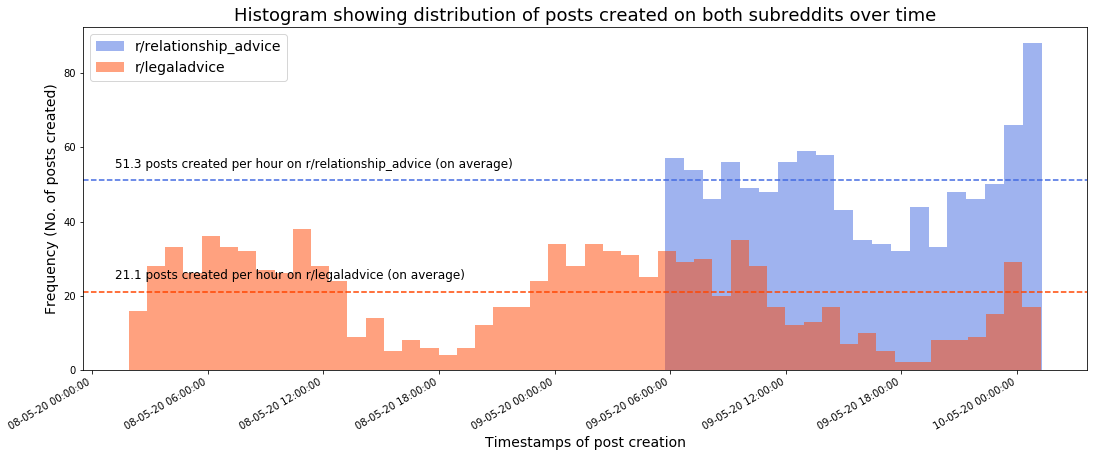

In [49]:
# Plotting histograms to show no. of posts created over time.

fig, ax = plt.subplots(figsize=(18,7))

plt.hist(relad_raw['created_utc'], bins=20, color='royalblue', alpha=0.5, label='r/relationship_advice')
plt.hist(legad_raw['created_utc'], bins=50, color='orangered', alpha=0.5, label='r/legaladvice')


# Plotting horizontal lines to show average no. of posts created per hour.
plt.axhline(relad_avg_posts, ls='--', color='royalblue')
plt.figtext(x=0.15, y=0.6, s=f"{round(relad_avg_posts, 1)} posts created per hour on r/relationship_advice (on average)", fontsize=12)

plt.axhline(legad_avg_posts, ls='--', color='orangered')
plt.figtext(x=0.15, y=0.38, s=f"{round(legad_avg_posts, 1)} posts created per hour on r/legaladvice (on average)", fontsize=12)


# Setting format of timestamps on X-axis
# Code taken from https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/date.html
date_fmt = '%d-%m-%y %H:%M:%S'
date_formatter = mdate.DateFormatter(date_fmt)
ax.xaxis.set_major_formatter(date_formatter)
fig.autofmt_xdate()


plt.legend(fontsize=14)

plt.xlabel("Timestamps of post creation", fontsize=14)
plt.ylabel("Frequency (No. of posts created)", fontsize=14)

plt.title("Histogram showing distribution of posts created on both subreddits over time", loc='center', fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/histogram_posts_over_time.png', bbox_inches='tight');

**Above plots clearly shows the difference in level of activity on *r/relationship_advice* and *r/legaladvice*** (as explained above as well).

From the histograms of *r/legaladvice*, I also notice that the posts tend to follow a cyclical trend over time (with more posts between 11pm-1pm and lesser posts between 1pm-11pm). Although I do not have enough data to conclusively notice this trend in both subreddits, this could potentially imply that these subreddits have majority of their posts coming from users who live in the same timezone (probably one country).

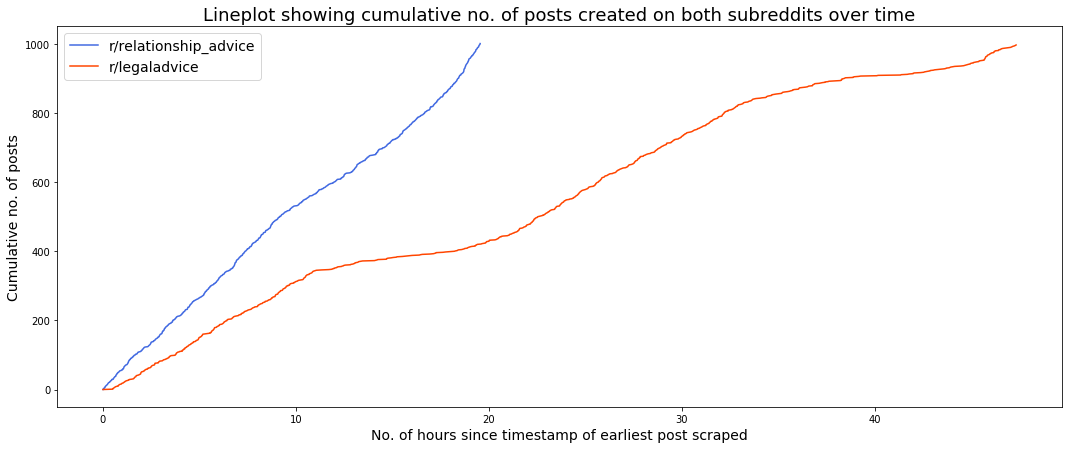

In [50]:
# Plotting lineplots to show cumulative no. of posts created over time.

plt.figure(figsize=(18,7))

plt.plot(relad_raw['created_norm']/3600, relad_raw['cumulative_posts'], color='royalblue', label='r/relationship_advice')
plt.plot(legad_raw['created_norm']/3600, legad_raw['cumulative_posts'], color='orangered', label='r/legaladvice')

#plt.plot(relad_raw['created_utc'], relad_raw['ups'])

plt.legend(fontsize=14)

plt.xlabel("No. of hours since timestamp of earliest post scraped", fontsize=14)
plt.ylabel("Cumulative no. of posts", fontsize=14)

plt.title("Lineplot showing cumulative no. of posts created on both subreddits over time", loc='center', fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/lineplot_posts_over_time.png', bbox_inches='tight');

**Above plots clearly shows the difference in level of activity on *r/relationship_advice* and *r/legaladvice*** (as explained above as well). It took 47 hours 19 mins for 1000 posts to be created on *r/legaladvice*. In contrast to this, it *only* took 19 hours 33 minutes for 1000 posts to be created on *r/relationship_advice*.

**The massive amount of activity on *r/relationship_advice* could be attributed to the fact that more couples are now either isolated indoors *with* each other, or separated (socially distanced) *from* each other, due to the current COVID-19 situation, as suggested in this [article](https://jezebel.com/coronavirus-is-pushing-reddits-relationship_advice-to-a-1842476984).**

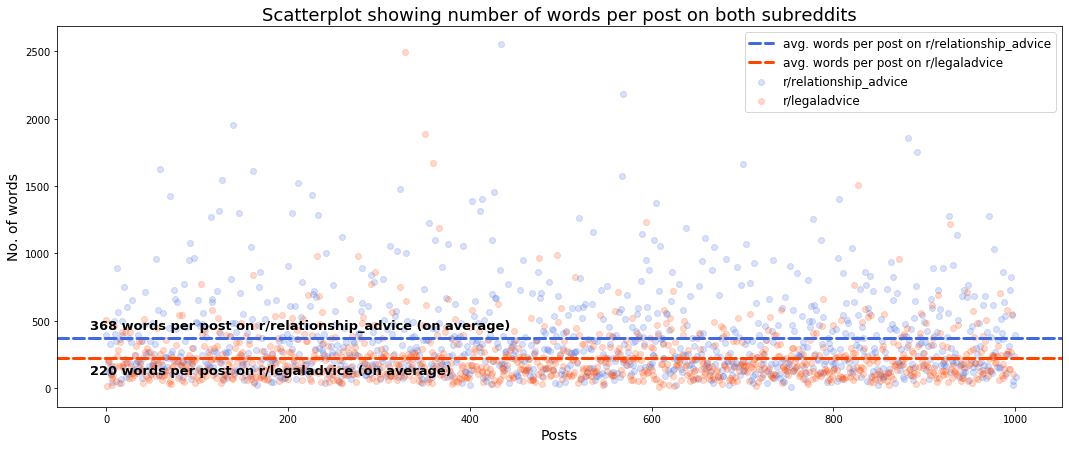

In [51]:
# Plotting scatterplot to show no. of words per post on both subreddits.

fig, ax = plt.subplots(figsize=(18,7))

plt.scatter(relad_raw.index, relad_raw['post_length'], color='royalblue', alpha=0.2, label='r/relationship_advice')
plt.scatter(legad_raw.index, legad_raw['post_length'], color='orangered', alpha=0.2, label='r/legaladvice')

# Plotting horizontal lines to show average no. of words for posts in both subreddits.
plt.axhline(relad_mean_post_length,
            label='avg. words per post on r/relationship_advice',
            ls='--',
            linewidth=3,
            color='royalblue',
            dash_capstyle='round',
           )
plt.figtext(x=0.15,
            y=0.28,
            s=f"{int(round(relad_mean_post_length, 0))} words per post on r/relationship_advice (on average)",
            fontsize=13,
            fontweight='semibold'
           )

plt.axhline(legad_mean_post_length,
            label='avg. words per post on r/legaladvice',
            ls='--',
            linewidth=3,
            color='orangered',
            dash_capstyle='round',
           )
plt.figtext(x=0.15,
            y=0.19,
            s=f"{int(round(legad_mean_post_length, 0))} words per post on r/legaladvice (on average)",
            fontsize=13,
            fontweight='semibold'
           )


plt.legend(fontsize=12)

plt.xlabel("Posts", fontsize=14)
plt.ylabel("No. of words", fontsize=14)

plt.title("Scatterplot showing number of words per post on both subreddits", loc='center', fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/scatterplot_words_per_post.png', bbox_inches='tight');

The scatterplot above shows the number of words per post on both *r/relationship_advice* and *r/legaladvice*. On average, the **posts on *r/relationship_advice* are significantly longer than those on *r/legaladvice*** - 368 words per post on *r/relationship_advice* as compared to 200 words per post on *r/legaladvice*. This could have an impact on the classification model that will be built later on. Since the number of words per post differ significantly, it would mean that there are more words (and hence more data) available from *r/relationship_advice* as compared to *r/legaladvice*. **This could result in the classification model being skewed towards *r/relationship_advice***, with posts from it being classified at a better rate than the posts from *r/legaladvice*.

### Visualizing Differences in Posts

In [52]:
relad_raw.head()

,subreddit,name,title,selftext,num_comments,created_utc,cumulative_posts,created_norm,all_text,post_length,all_text_cleaned
0,relationship_advice,t3_gg2dl4,I (18M) game 2 times 2 hours a week and my gf(...,Like I stated in the title. I dont know if i'm...,6,2020-05-09 05:43:34,0,0.0,I (18M) game 2 times 2 hours a week and my gf(...,395,game times hours week gf f finds big deal like...
1,relationship_advice,t3_gg2dwy,How to overcome envy,I’m currently in a relationship which is very ...,1,2020-05-09 05:44:05,1,31.0,How to overcome envy I’m currently in a relati...,123,overcome envy currently important financially ...
2,relationship_advice,t3_gg2eob,A couple in there 40s strangely talked to me.,So this was about a couple of years ago and I ...,1,2020-05-09 05:45:13,2,99.0,A couple in there 40s strangely talked to me. ...,196,couple strangely talked couple years ago time ...
3,relationship_advice,t3_gg2fij,How do I tell a female friend that she is in a...,(I'll call my friend Claire and his boyfriend ...,3,2020-05-09 05:46:29,3,175.0,How do I tell a female friend that she is in a...,120,tell female friend toxic call friend claire bo...
4,relationship_advice,t3_gg2fku,"My (23m) gf (23f) was raped before I met her, ...",Me and my gf have been together not far off a ...,10,2020-05-09 05:46:35,4,181.0,"My (23m) gf (23f) was raped before I met her, ...",329,gf f raped met also rape kink wants fulfill gf...


In [53]:
# Preparing text for word cloud.
# Wordcloud accepts one string as text argument. So, I will combine all documents from all_text_cleaned column into one long string.

relad_text = ""
for text in relad_raw['all_text_cleaned']:
    relad_text = relad_text + " " + text
    
legad_text = ""
for text in legad_raw['all_text_cleaned']:
    legad_text = legad_text + " " + text

The following wordclouds are generated with help from this [page](https://www.datacamp.com/community/tutorials/wordcloud-python). **For both wordclouds, I will apply a mask to change their shape. The masking procedure is as explained below.**

In [54]:
# Importing the masking PNG figure as a numpy array. This figure will be used as a mask for the wordcloud.
heart_mask = np.array(Image.open("../assets/heart_mask.png"))

In [55]:
heart_mask.shape

(1058, 1200, 4)

In [56]:
# RGBA values of the FIRST pixel in heart_mask image.

heart_mask[0][0]

array([0, 0, 0, 0], dtype=uint8)

Above *heart_mask* gets imported as a 3-dimensional array. The first dimension *(1058)* corresponds to the height of the image. The second dimension *(1200)* corresponds to the breadth of the image. The third dimension *(4)* corresponds to the RGBA (Red, Green, Blue, Alpha) values of each pixel.

In order to use this image as a mask, I will have to convert the above 3-dimensional array into a 2-dimensional array, with just one single value (instead of the four I currently have) for each pixel - **255 for white colour and 1 for black colour**.

The following function will perform the transformation.

In [57]:
# Initializing a new 2-dim integer array with same dimensions as heart_mask above.
transformed_heart_mask = np.ndarray((heart_mask.shape[0], heart_mask.shape[1]), np.int32)

# Running for loops along the height and breadth of the image to access each pixel.
for height in range(heart_mask.shape[0]):
    for breadth in range(heart_mask.shape[1]):
        
        # Assigning the R, G & B values of the current pixel to variables.
        r = heart_mask[height][breadth][0]
        g = heart_mask[height][breadth][1]
        b = heart_mask[height][breadth][2]
        
        # If R, G & B are all 0 (the pixel colour is black), assign this pixel in transformed_heart_mask as 255.
        # For any other values of R, G & B, assign this pixel in transformed_heart_mask as 1.
        if r == g == b == 0:
            transformed_heart_mask[height][breadth] = 255
        else:
            transformed_heart_mask[height][breadth] = 1

In [58]:
# Checking FIRST pixel in transformed_heart_mask to ensure correct transformation.

transformed_heart_mask[0][0]

255

In [59]:
transformed_heart_mask.shape

(1058, 1200)

Now that the mask is ready, I can make the **word cloud for *r/relationship_advice***.

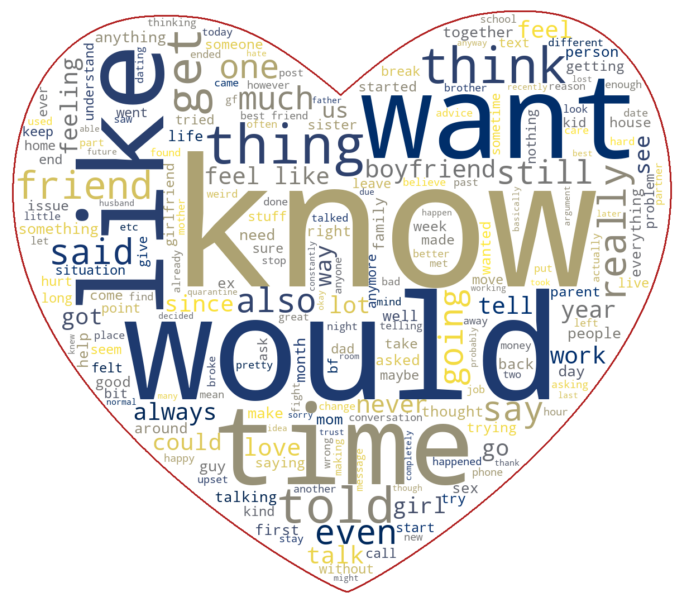

In [60]:
# Creating a wordcloud for r/relationship_advice.

plt.figure(figsize=(12,12))

# Creating a wordcloud object
relad_wordcloud = WordCloud(max_words=220,
                            collocations = True,
                            stopwords={},
                            background_color='white',
                            width=400,
                            height=400,
                            mask=transformed_heart_mask,
                            colormap='cividis',
                            contour_width=3,
                            contour_color='firebrick'
                           )

relad_wordcloud.generate(relad_text)

# Displaying the generated image.
plt.imshow(relad_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Exporting word cloud image in PNG format.
relad_wordcloud.to_file('../plot_images/wordcloud_rel_adv.png');

In [61]:
# Looking at word tokens with associated frequencies (already sorted by frequency in descending order) using the .words_ attribute.

relad_wordcloud.words_

{'know': 1.0,
 'would': 0.9590773809523809,
 'want': 0.8779761904761905,
 'like': 0.8586309523809523,
 'time': 0.8050595238095238,
 'thing': 0.7827380952380952,
 'think': 0.6525297619047619,
 'told': 0.6421130952380952,
 'get': 0.6413690476190477,
 'friend': 0.6391369047619048,
 'really': 0.6220238095238095,
 'said': 0.5372023809523809,
 'say': 0.5007440476190477,
 'even': 0.5007440476190477,
 'also': 0.48735119047619047,
 'one': 0.4851190476190476,
 'going': 0.4680059523809524,
 'still': 0.4494047619047619,
 'much': 0.4367559523809524,
 'boyfriend': 0.43526785714285715,
 'never': 0.42782738095238093,
 'talk': 0.41443452380952384,
 'love': 0.40848214285714285,
 'tell': 0.38913690476190477,
 'year': 0.3861607142857143,
 'always': 0.38244047619047616,
 'lot': 0.3757440476190476,
 'feel': 0.3712797619047619,
 'feel like': 0.36904761904761907,
 'feeling': 0.36830357142857145,
 'work': 0.36160714285714285,
 'could': 0.3430059523809524,
 'go': 0.34226190476190477,
 'got': 0.34077380952380953

Following the same technique as above, I will now create a **wordcloud for *r/legal_advice***.

In [62]:
legad_raw.head()

,subreddit,name,title,selftext,num_comments,created_utc,cumulative_posts,created_norm,all_text,post_length,all_text_cleaned
0,legaladvice,t3_gfbiey,Can I legally sell my Ex boyfriends furniture ...,I posted in AITA and someone suggested that I ...,2,2020-05-08 01:53:59,0,0.0,Can I legally sell my Ex boyfriends furniture ...,505,legally sell ex boyfriends furniture year post...
1,legaladvice,t3_gfc3xm,"Tried to move out, things are getting ugly (Un...","NC,US \nhttps://www.reddit.com/user/youknowdav...",1,2020-05-08 02:24:28,1,1829.0,"Tried to move out, things are getting ugly (Un...",12,tried move things getting ugly university stud...
2,legaladvice,t3_gfc48y,Live-in position/apartment rights,"Hey all, hope everyone is managing the best th...",0,2020-05-08 02:24:55,2,1856.0,"Live-in position/apartment rights Hey all, hop...",211,live-in position apartment rights hey hope eve...
3,legaladvice,t3_gfc4eo,Being Forced To Work At A Nonessential Job In ...,"This takes place in Pennsylvania, in a county ...",6,2020-05-08 02:25:10,3,1871.0,Being Forced To Work At A Nonessential Job In ...,198,forced work nonessential job county still red ...
4,legaladvice,t3_gfc5vg,Handling difficult tenant - CO,"Hey all, \n\nMy last post explained my living ...",2,2020-05-08 02:27:17,4,1998.0,"Handling difficult tenant - CO Hey all, \n\nMy...",155,handling difficult tenant - co hey last post e...


In [63]:
# Importing the masking PNG figure as a numpy array. This figure will be used as a mask for the wordcloud.
courthouse_mask = np.array(Image.open("../assets/courthouse_mask.png"))

In [64]:
courthouse_mask.shape

(943, 1058, 4)

In [65]:
# RGBA values of the FIRST pixel in courthouse_mask image.

courthouse_mask[0][0]

array([0, 0, 0, 0], dtype=uint8)

In [66]:
# Initializing a new 2-dim integer array with same dimensions as courthouse_mask above.
transformed_courthouse_mask = np.ndarray((courthouse_mask.shape[0], courthouse_mask.shape[1]), np.int32)

# Running for loops along the height and breadth of the image to access each pixel.
for height in range(courthouse_mask.shape[0]):
    for breadth in range(courthouse_mask.shape[1]):
        
        # Assigning the R, G & B values of the current pixel to variables.
        r = courthouse_mask[height][breadth][0]
        g = courthouse_mask[height][breadth][1]
        b = courthouse_mask[height][breadth][2]
        
        # If R, G & B are all 0 (the pixel colour is black), assign this pixel in transformed_courthouse_mask as 255.
        # For any other values of R, G & B, assign this pixel in transformed_courthouse_mask as 1.
        if r == g == b == 0:
            transformed_courthouse_mask[height][breadth] = 255
        else:
            transformed_courthouse_mask[height][breadth] = 1

In [67]:
# Checking FIRST pixel in transformed_courthouse_mask to ensure correct transformation.

transformed_courthouse_mask[0][0]

255

In [68]:
transformed_courthouse_mask.shape

(943, 1058)

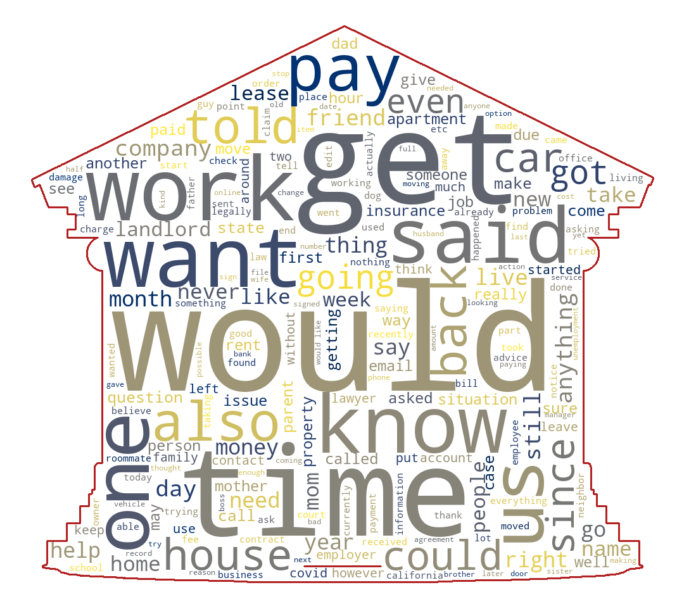

In [69]:
# Creating a wordcloud for r/legaladvice.

plt.figure(figsize=(12,12))

# Creating a wordcloud object
legad_wordcloud = WordCloud(max_words=220,
                            collocations = True,
                            stopwords={},
                            background_color='white',
                            width=400,
                            height=400,
                            mask=transformed_courthouse_mask,
                            colormap='cividis',
                            contour_width=3,
                            contour_color='firebrick'
                           )

legad_wordcloud.generate(legad_text)

# Displaying the generated image.
plt.imshow(legad_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Exporting word cloud image in PNG format.
legad_wordcloud.to_file('../plot_images/wordcloud_leg_adv.png');

In [70]:
# Looking at word tokens with associated frequencies (already sorted by frequency in descending order) using the .words_ attribute.

legad_wordcloud.words_

{'would': 1.0,
 'get': 0.7492957746478873,
 'time': 0.6830985915492958,
 'work': 0.6676056338028169,
 'want': 0.6450704225352113,
 'know': 0.604225352112676,
 'one': 0.5887323943661972,
 'said': 0.5633802816901409,
 'us': 0.5366197183098591,
 'pay': 0.5225352112676056,
 'also': 0.5211267605633803,
 'told': 0.5169014084507042,
 'back': 0.5028169014084507,
 'house': 0.49859154929577465,
 'could': 0.4971830985915493,
 'car': 0.4971830985915493,
 'since': 0.44647887323943664,
 'going': 0.43380281690140843,
 'even': 0.4323943661971831,
 'got': 0.4253521126760563,
 'company': 0.4253521126760563,
 'still': 0.4225352112676056,
 'anything': 0.4197183098591549,
 'day': 0.4140845070422535,
 'friend': 0.3957746478873239,
 'live': 0.3873239436619718,
 'year': 0.37464788732394366,
 'need': 0.3732394366197183,
 'thing': 0.3704225352112676,
 'right': 0.3676056338028169,
 'money': 0.3619718309859155,
 'month': 0.35774647887323946,
 'help': 0.34788732394366195,
 'say': 0.3464788732394366,
 'go': 0.33943

The above wordclouds show that, inspite of removing all stopwords, **there are still a lot of words which are similar in both subreddit datasets**. I will now **list the 20 most prominent words in both wordclouds above, and from them, remove any words which occur in both wordclouds**.

In [71]:
# Listing down the 20 most prominent words in both wordclouds from the .words_ attribute.

relad_prom_words = list(relad_wordcloud.words_.keys())[:20]
legad_prom_words = list(legad_wordcloud.words_.keys())[:20]

In [72]:
# Checking the common words between both lists from above to filter out the most prominent common words in both wordclouds.

common_words = set(relad_prom_words).intersection(set(legad_prom_words))
common_words

{'also',
 'even',
 'get',
 'going',
 'know',
 'one',
 'said',
 'time',
 'told',
 'want',
 'would'}

In [73]:
# Defining a function to remove common_words from all_text_cleaned column.
def remove_common_words(text):
    
    # Removing common words as defined in set common_words above.
    text_comm_words_removed = [word for word in text.split(" ") if word not in common_words]
    
    # Returning a string of all words joined together with spaces in between.
    return " ".join(text_comm_words_removed)

In [74]:
relad_clean_text = []
legad_clean_text = []

print("\nRemoving common words from posts from r/relationship_advice...\n")

counter = 0
for i, text in enumerate(relad_raw['all_text_cleaned']):
    
    relad_clean_text.append(remove_common_words(text))
    
    counter += 1
    if counter % 100 == 0:
        print(f"{counter} of {relad_raw.shape[0]} posts cleaned.")
        
print(f"\nAll {relad_raw.shape[0]} posts from r/relationship_advice cleaned.")

relad_raw['all_text_cleaned'] = relad_clean_text

print("\nRemoving common words from posts from r/legaladvice...\n")

counter = 0
for i, text in enumerate(legad_raw['all_text_cleaned']):
    
    legad_clean_text.append(remove_common_words(text))
    
    counter += 1
    if counter % 100 == 0:
        print(f"{counter} of {legad_raw.shape[0]} posts cleaned.")
        
print(f"\nAll {legad_raw.shape[0]} posts from r/legaladvice cleaned.")

legad_raw['all_text_cleaned'] = legad_clean_text


Removing common words from posts from r/relationship_advice...

100 of 1002 posts cleaned.
200 of 1002 posts cleaned.
300 of 1002 posts cleaned.
400 of 1002 posts cleaned.
500 of 1002 posts cleaned.
600 of 1002 posts cleaned.
700 of 1002 posts cleaned.
800 of 1002 posts cleaned.
900 of 1002 posts cleaned.
1000 of 1002 posts cleaned.

All 1002 posts from r/relationship_advice cleaned.

Removing common words from posts from r/legaladvice...

100 of 998 posts cleaned.
200 of 998 posts cleaned.
300 of 998 posts cleaned.
400 of 998 posts cleaned.
500 of 998 posts cleaned.
600 of 998 posts cleaned.
700 of 998 posts cleaned.
800 of 998 posts cleaned.
900 of 998 posts cleaned.

All 998 posts from r/legaladvice cleaned.


Now that the **most-prominent common words have been removed from both subreddit datasets**, I can make the wordclouds again.

In [75]:
# Preparing text for word cloud.
# Wordcloud accepts one string as text argument. So, I will combine all documents from all_text_cleaned column into one long string.

relad_text = ""
for text in relad_raw['all_text_cleaned']:
    relad_text = relad_text + " " + text
    
legad_text = ""
for text in legad_raw['all_text_cleaned']:
    legad_text = legad_text + " " + text

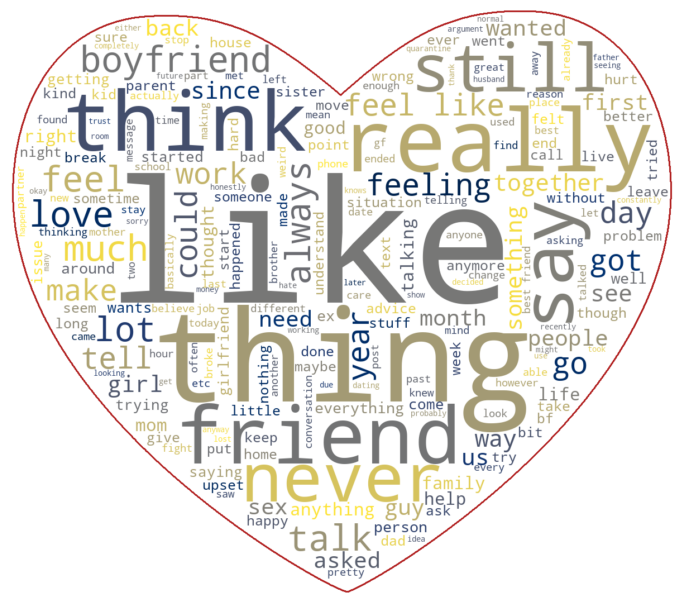

In [76]:
# Creating a wordcloud for r/relationship_advice after removing common words from both subreddit datasets.

plt.figure(figsize=(12,12))

# Creating a wordcloud object
relad_wordcloud = WordCloud(max_words=220,
                            collocations = True,
                            stopwords={},
                            background_color='white',
                            width=400,
                            height=400,
                            mask=transformed_heart_mask,
                            colormap='cividis',
                            contour_width=3,
                            contour_color='firebrick'
                           )

relad_wordcloud.generate(relad_text)

# Displaying the generated image.
plt.imshow(relad_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Exporting word cloud image in PNG format.
relad_wordcloud.to_file('../plot_images/wordcloud_rel_adv_comm_words_removed.png');

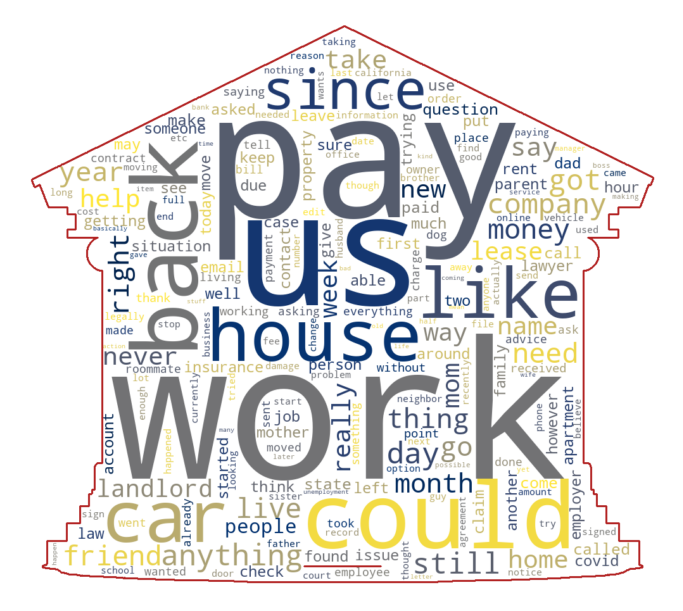

In [77]:
# Creating a wordcloud for r/legaladvice after removing common words from both subreddit datasets.

plt.figure(figsize=(12,12))

# Creating a wordcloud object
legad_wordcloud = WordCloud(max_words=220,
                            collocations = True,
                            stopwords={},
                            background_color='white',
                            width=400,
                            height=400,
                            mask=transformed_courthouse_mask,
                            colormap='cividis',
                            contour_width=3,
                            contour_color='firebrick'
                           )

legad_wordcloud.generate(legad_text)

# Displaying the generated image.
plt.imshow(legad_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Exporting word cloud image in PNG format.
legad_wordcloud.to_file('../plot_images/wordcloud_leg_adv_comm_words_removed.png');

The above wordclouds show that **after removing the common most prominent words, the posts from the two subreddits are composed of somewhat different sets of words**. This may be a good indication for classification modelling, and may result in highly accurate classification models.

I will now **stem the words in all documents** of both the subreddit corpora.

In [78]:
relad_raw.head()

,subreddit,name,title,selftext,num_comments,created_utc,cumulative_posts,created_norm,all_text,post_length,all_text_cleaned
0,relationship_advice,t3_gg2dl4,I (18M) game 2 times 2 hours a week and my gf(...,Like I stated in the title. I dont know if i'm...,6,2020-05-09 05:43:34,0,0.0,I (18M) game 2 times 2 hours a week and my gf(...,395,game times hours week gf f finds big deal like...
1,relationship_advice,t3_gg2dwy,How to overcome envy,I’m currently in a relationship which is very ...,1,2020-05-09 05:44:05,1,31.0,How to overcome envy I’m currently in a relati...,123,overcome envy currently important financially ...
2,relationship_advice,t3_gg2eob,A couple in there 40s strangely talked to me.,So this was about a couple of years ago and I ...,1,2020-05-09 05:45:13,2,99.0,A couple in there 40s strangely talked to me. ...,196,couple strangely talked couple years ago anywa...
3,relationship_advice,t3_gg2fij,How do I tell a female friend that she is in a...,(I'll call my friend Claire and his boyfriend ...,3,2020-05-09 05:46:29,3,175.0,How do I tell a female friend that she is in a...,120,tell female friend toxic call friend claire bo...
4,relationship_advice,t3_gg2fku,"My (23m) gf (23f) was raped before I met her, ...",Me and my gf have been together not far off a ...,10,2020-05-09 05:46:35,4,181.0,"My (23m) gf (23f) was raped before I met her, ...",329,gf f raped met rape kink wants fulfill gf toge...


In [79]:
legad_raw.head()

,subreddit,name,title,selftext,num_comments,created_utc,cumulative_posts,created_norm,all_text,post_length,all_text_cleaned
0,legaladvice,t3_gfbiey,Can I legally sell my Ex boyfriends furniture ...,I posted in AITA and someone suggested that I ...,2,2020-05-08 01:53:59,0,0.0,Can I legally sell my Ex boyfriends furniture ...,505,legally sell ex boyfriends furniture year post...
1,legaladvice,t3_gfc3xm,"Tried to move out, things are getting ugly (Un...","NC,US \nhttps://www.reddit.com/user/youknowdav...",1,2020-05-08 02:24:28,1,1829.0,"Tried to move out, things are getting ugly (Un...",12,tried move things getting ugly university stud...
2,legaladvice,t3_gfc48y,Live-in position/apartment rights,"Hey all, hope everyone is managing the best th...",0,2020-05-08 02:24:55,2,1856.0,"Live-in position/apartment rights Hey all, hop...",211,live-in position apartment rights hey hope eve...
3,legaladvice,t3_gfc4eo,Being Forced To Work At A Nonessential Job In ...,"This takes place in Pennsylvania, in a county ...",6,2020-05-08 02:25:10,3,1871.0,Being Forced To Work At A Nonessential Job In ...,198,forced work nonessential job county still red ...
4,legaladvice,t3_gfc5vg,Handling difficult tenant - CO,"Hey all, \n\nMy last post explained my living ...",2,2020-05-08 02:27:17,4,1998.0,"Handling difficult tenant - CO Hey all, \n\nMy...",155,handling difficult tenant - co hey last post e...


In [80]:
# Defining a function to stem words from all_text_cleaned column.
def stem_words(text):
    
    # Stemming all words using list comprehension.
    text_stemmed = [PorterStemmer().stem(word) for word in text.split(" ")]
    
    # Returning a string of all words joined together with spaces in between.
    return " ".join(text_stemmed)

In [81]:
# Stemming using PorterStemmer

relad_stemmed_text = []
legad_stemmed_text = []

print("\nStemming words from posts from r/relationship_advice...\n")

counter = 0
for i, text in enumerate(relad_raw['all_text_cleaned']):
    
    relad_stemmed_text.append(stem_words(text))
    
    counter += 1
    if counter % 100 == 0:
        print(f"{counter} of {relad_raw.shape[0]} posts stemmed.")
        
print(f"\nAll {relad_raw.shape[0]} posts from r/relationship_advice stemmed.")

relad_raw['all_text_cleaned'] = relad_stemmed_text

print("\nStemming words from posts from r/legaladvice...\n")

counter = 0
for i, text in enumerate(legad_raw['all_text_cleaned']):
    
    legad_stemmed_text.append(stem_words(text))
    
    counter += 1
    if counter % 100 == 0:
        print(f"{counter} of {legad_raw.shape[0]} posts stemmed.")
        
print(f"\nAll {legad_raw.shape[0]} posts from r/legaladvice stemmed.")

legad_raw['all_text_cleaned'] = legad_stemmed_text


Stemming words from posts from r/relationship_advice...

100 of 1002 posts stemmed.
200 of 1002 posts stemmed.
300 of 1002 posts stemmed.
400 of 1002 posts stemmed.
500 of 1002 posts stemmed.
600 of 1002 posts stemmed.
700 of 1002 posts stemmed.
800 of 1002 posts stemmed.
900 of 1002 posts stemmed.
1000 of 1002 posts stemmed.

All 1002 posts from r/relationship_advice stemmed.

Stemming words from posts from r/legaladvice...

100 of 998 posts stemmed.
200 of 998 posts stemmed.
300 of 998 posts stemmed.
400 of 998 posts stemmed.
500 of 998 posts stemmed.
600 of 998 posts stemmed.
700 of 998 posts stemmed.
800 of 998 posts stemmed.
900 of 998 posts stemmed.

All 998 posts from r/legaladvice stemmed.


In [82]:
relad_raw.shape

(1002, 11)

In [83]:
legad_raw.shape

(998, 11)

## Classification Modelling

### Model Preparation

Now that all the documents in both subreddit corpora have been cleaned and pre-processed, I will **combine the two corpora into one single corpus**. I will also shuffle all the rows in the combined dataframe so as to mix them.

In [84]:
# Combining the two subreddit datasets into one single dataframe to prepare for classification modelling.

combined_df = pd.concat([relad_raw, legad_raw], axis=0).reset_index(drop=True)
combined_df.shape

(2000, 11)

In [85]:
combined_df.head()

,subreddit,name,title,selftext,num_comments,created_utc,cumulative_posts,created_norm,all_text,post_length,all_text_cleaned
0,relationship_advice,t3_gg2dl4,I (18M) game 2 times 2 hours a week and my gf(...,Like I stated in the title. I dont know if i'm...,6,2020-05-09 05:43:34,0,0.0,I (18M) game 2 times 2 hours a week and my gf(...,395,game time hour week gf f find big deal like st...
1,relationship_advice,t3_gg2dwy,How to overcome envy,I’m currently in a relationship which is very ...,1,2020-05-09 05:44:05,1,31.0,How to overcome envy I’m currently in a relati...,123,overcom envi current import financi depend par...
2,relationship_advice,t3_gg2eob,A couple in there 40s strangely talked to me.,So this was about a couple of years ago and I ...,1,2020-05-09 05:45:13,2,99.0,A couple in there 40s strangely talked to me. ...,196,coupl strang talk coupl year ago anyway movi f...
3,relationship_advice,t3_gg2fij,How do I tell a female friend that she is in a...,(I'll call my friend Claire and his boyfriend ...,3,2020-05-09 05:46:29,3,175.0,How do I tell a female friend that she is in a...,120,tell femal friend toxic call friend clair boyf...
4,relationship_advice,t3_gg2fku,"My (23m) gf (23f) was raped before I met her, ...",Me and my gf have been together not far off a ...,10,2020-05-09 05:46:35,4,181.0,"My (23m) gf (23f) was raped before I met her, ...",329,gf f rape met rape kink want fulfil gf togeth ...


In [86]:
# Shuffling the rows of combined_df so as to mix together the rows coming from both subreddit datasets.

combined_df = shuffle(combined_df).reset_index(drop=True)
combined_df.head()

,subreddit,name,title,selftext,num_comments,created_utc,cumulative_posts,created_norm,all_text,post_length,all_text_cleaned
0,relationship_advice,t3_gg5aci,"Neighbors leave dog outside 24/7, and the bark...","Moved into a new community over a year ago, qu...",24,2020-05-09 08:33:47,150,10213.0,"Neighbors leave dog outside 24/7, and the bark...",190,neighbor leav dog outsid bark becom unbear mov...
1,legaladvice,t3_gflau3,What is up with these harrasing text messages?,I'm getting these phishing text messages. They...,2,2020-05-08 11:12:45,289,33526.0,What is up with these harrasing text messages?...,70,harras text messag get phish text messag say s...
2,legaladvice,t3_gge7p9,Is this harassment?,I live in New Mexico. My company hired ny est...,1,2020-05-09 19:56:41,916,151362.0,Is this harassment? I live in New Mexico. My ...,76,harass live new mexico compani hire ny estrang...
3,legaladvice,t3_gfk5m8,[AB Canada] I ordered a legal gun that became ...,"Hey Reddit, I currently live in Alberta. On Ap...",0,2020-05-08 09:56:47,244,28968.0,[AB Canada] I ordered a legal gun that became ...,311,ab canada order gun becam prohibit ship licens...
4,relationship_advice,t3_gg6tvz,I simply don’t want to even argue anymore,My boyfriend (23M) is great. I (23F) love him ...,4,2020-05-09 10:13:36,244,16202.0,I simply don’t want to even argue anymore My b...,222,simpli argu anymor boyfriend great f love both...


I will now **create the target variable** to be used in classification modelling. From this point forward in all classification models, the **positive class (1) will be *r/relationship_advice*** and the **negative class (0) will be *r/legaladvice***.

In [87]:
# Creating the target variable for classification modelling (1 for r/relationship_advice & 0 for r/legal_advice).

combined_df['target'] = [1 if sub == 'relationship_advice' else 0 for sub in combined_df['subreddit']]
combined_df.head()

,subreddit,name,title,selftext,num_comments,created_utc,cumulative_posts,created_norm,all_text,post_length,all_text_cleaned,target
0,relationship_advice,t3_gg5aci,"Neighbors leave dog outside 24/7, and the bark...","Moved into a new community over a year ago, qu...",24,2020-05-09 08:33:47,150,10213.0,"Neighbors leave dog outside 24/7, and the bark...",190,neighbor leav dog outsid bark becom unbear mov...,1
1,legaladvice,t3_gflau3,What is up with these harrasing text messages?,I'm getting these phishing text messages. They...,2,2020-05-08 11:12:45,289,33526.0,What is up with these harrasing text messages?...,70,harras text messag get phish text messag say s...,0
2,legaladvice,t3_gge7p9,Is this harassment?,I live in New Mexico. My company hired ny est...,1,2020-05-09 19:56:41,916,151362.0,Is this harassment? I live in New Mexico. My ...,76,harass live new mexico compani hire ny estrang...,0
3,legaladvice,t3_gfk5m8,[AB Canada] I ordered a legal gun that became ...,"Hey Reddit, I currently live in Alberta. On Ap...",0,2020-05-08 09:56:47,244,28968.0,[AB Canada] I ordered a legal gun that became ...,311,ab canada order gun becam prohibit ship licens...,0
4,relationship_advice,t3_gg6tvz,I simply don’t want to even argue anymore,My boyfriend (23M) is great. I (23F) love him ...,4,2020-05-09 10:13:36,244,16202.0,I simply don’t want to even argue anymore My b...,222,simpli argu anymor boyfriend great f love both...,1


In [88]:
# Checking for unbalanced classes.
# Since ~1000 posts from each subreddit were added, the classes are very well balanced.

combined_df['target'].value_counts(normalize=True)

1    0.501
0    0.499
Name: target, dtype: float64

Since ~1000 posts were added into *combined_df* from each subreddit, the **classes are very well balanced**.

Also, from above, my **baseline accuracy is 50.1%**. If I were to not do any classification modelling, and just assign every post to my positive class *(r/relationship_advice)*, I would classify 50.1% of the posts correctly.

Hence, **any classification model built for this dataset must have an accuracy higher than the baseline accuracy of 50.1%**.

In [89]:
# Defining the classifier feature X and target variable y.

X = combined_df['all_text_cleaned']
y = combined_df['target']

In [90]:
X[:10]

0    neighbor leav dog outsid bark becom unbear mov...
1    harras text messag get phish text messag say s...
2    harass live new mexico compani hire ny estrang...
3    ab canada order gun becam prohibit ship licens...
4    simpli argu anymor boyfriend great f love both...
5    cancel leas ontario canada ago sign standard f...
6    receiv trespass warn pull someon driveway edit...
7    bf advic boyfriend long distanc onlin year too...
8    employ pressur return work high risk exposur e...
9    break gf f pleas forgiv english bad togeth lit...
Name: all_text_cleaned, dtype: object

In [91]:
y[:10]

0    1
1    0
2    0
3    0
4    1
5    0
6    0
7    1
8    0
9    1
Name: target, dtype: int64

In [92]:
# Splitting the features and target variable datasets into training and testing datasets with stratify=y. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [93]:
X_train.shape

(1500,)

In [94]:
X_train.head()

994     child labor law question florida year old mino...
911     end leas move woke text bf tell move togeth an...
1936    friendship friend f need person like due fact ...
362     final abl speak say love anymor past day text ...
568     bf younger brother disrespect seem like despit...
Name: all_text_cleaned, dtype: object

In [95]:
X_test.shape

(500,)

In [96]:
X_test.head()

542    father-in-law su accid happen drove car ca qui...
718    tx got good deal apart third-parti servic rais...
21     birthday surpris provid girlfriend best birthd...
730    husband seem compat everyth except sex cheat g...
5      cancel leas ontario canada ago sign standard f...
Name: all_text_cleaned, dtype: object

In [97]:
y_train.value_counts(normalize=True)

1    0.500667
0    0.499333
Name: target, dtype: float64

In [98]:
y_test.value_counts(normalize=True)

1    0.502
0    0.498
Name: target, dtype: float64

### Classification Metrics

The possible classification metrics that can be used to gauge how well my models perform are *Accuracy, Misclassification Rate, Sensitivity (True Positive Rate), Specificity (True Negative Rate), Precision (Positive Predictive Value), F1 Score and ROC AUC*. However, in this project, I will **only use *Accuracy* as my metric** to determine the effectiveness of my models, as explained below:

In the context of classification of posts into subreddits, **it is equally bad to misclassify posts into either of the two classes *(positive class r/relationship_advice or negative class r/legaladvice)***. Hence, looking at the *Confusion Matrix* and calculating the *Sensitivity, Specificity, Precision* and *F1 Score* for every model built would not add much extra meaning to the effectiveness of the models.

However, **for the final chosen model, in addition to *Accuracy*, I will also look at the *Confusion Matrix* and calculate the *Sensitivity* and *Specificity* so as to gauge whether or not my classification model has any skewness towards either one of the two subreddits (as mentioned during EDA). I will also look at the *ROC AUC* score to gauge the degree of overlap between the words in posts from the two subreddits.**

### Vectorization of Words (CountVectorizer & TfidfVectorizer with LogisticRegression)

For this project, I will consider using two different NLP vectorizers - ***Count Vectorizer* and *TF-IDF Vectorizer*, both from *sklearn.feature_extraction.text*. I will try to select one of the two vectorizers to proceed with, and then build and iterate over classification models using the chosen vectorizer.**

In [99]:
# Creating two separate Pipeline objects with 2 different transformers (CountVectorizer and TfidfVectorizer), and 1 estimator (LogisticRegression).

pipe1 = Pipeline([('cvec1', CountVectorizer()),
                  ('logreg1', LogisticRegression())
                 ])

pipe2 = Pipeline([('tfvec2', TfidfVectorizer()),
                  ('logreg2', LogisticRegression())
                 ])

**The hyperparameters for *CountVectorizer* and *TfidfVectorizer* will be tuned using *GridSearchCV* below.**

**The hyperparameters for *LogisticRegression* have been left to their default values.** This was decided after iteratively changing the *penalty, solver, max_iter & tol* hyperparameters, along with the *C & l1_ratio* hyperparameters in *GridSearchCV* below. Due to the occurence of *ConvergenceError* in some hyperparameter combinations, and the limitations on computing power available (thus determining a limit on the hyperparameter combinations I can pass in *GridSearchCV*), I decided to return to the default values of *LogisticRegression* hyperparameters.

In [100]:
pipe1.get_params()

{'memory': None,
 'steps': [('cvec1',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, vocabulary=None)),
  ('logreg1',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'cvec1': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.int64'>, encoding='utf-8', input=

In [101]:
pipe2.get_params()

{'memory': None,
 'steps': [('tfvec2',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('logreg2',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'tfvec2': TfidfVectorizer(analyzer='word', binary=False, decode_e

In [102]:
# Establishing ranges of hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV.

pipe1_params = {'cvec1__max_features': [100, 200, 500, 800, 1000],
                'cvec1__min_df': [0.05, 0.10],
                'cvec1__max_df': [0.80, 0.90],
                'cvec1__ngram_range': [(1,1), (1,2)],
               }

pipe2_params = {'tfvec2__max_features': [100, 200, 500, 800, 1000],
                'tfvec2__min_df': [0.05, 0.10],
                'tfvec2__max_df': [0.80, 0.90],
                'tfvec2__ngram_range': [(1,1), (1,2)],
               }

**The above ranges of hyperparameters were also tuned iteratively using *GridSearchCV* before finally deciding on these ranges shown above.**

For example, the list of *max_features* for both *cvec1* and *tfvec2* was initially set to 1000, 2000 & 5000. Both the *GridSearchCV best_params_* below suggested a *max_features* value of 1000.

The range of *max_features* was then reduced to 500, 800 & 1000, for which both the *GridSearchCV best_params_* suggested a *max_features* value of 500.

The range of *max_features* was then further reduced to 100, 200, 500, 800 & 1000, for which both the *GridSearchCV best_params_* suggested a *max_features* value of 500 (as shown below). Hence, this range of *max_features* was chosen.

Similar iterations were done on the ranges of *min_df, max_df* and *ngram_range* hyperparameters as well.

In [103]:
# Creating two separate GridSearchCV objects for both Pipeline objects defined above (with 2 different transformers - CountVectorizer and TfidfVectorizer).

gs_pipe1 = GridSearchCV(pipe1, param_grid=pipe1_params, cv=5)

gs_pipe2 = GridSearchCV(pipe2, param_grid=pipe2_params, cv=5)

In [104]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec1',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pre

In [105]:
# Fitting GridSearchCV with TfidfVectorizer transformer on X_train and y_train.

gs_pipe2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfvec2',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        

In [106]:
# Best combination of hyperparameters suggested by GridSearchCV for CountVectorizer transformer.

gs_pipe1.best_params_

{'cvec1__max_df': 0.8,
 'cvec1__max_features': 500,
 'cvec1__min_df': 0.05,
 'cvec1__ngram_range': (1, 1)}

In [107]:
# Best combination of hyperparameters suggested by GridSearchCV for TfidfVectorizer transformer.

gs_pipe2.best_params_

{'tfvec2__max_df': 0.8,
 'tfvec2__max_features': 500,
 'tfvec2__min_df': 0.05,
 'tfvec2__ngram_range': (1, 2)}

In [108]:
# Summary scores from GridSearchCV with CountVectorizer and LogisticRegression.

print("CountVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe1.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe1.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe1.score(X_test, y_test), 3)}")

CountVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.938

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.998
Testing corpus accuracy = 0.93


In [109]:
# Summary scores from GridSearchCV with TfidfVectorizer and LogisticRegression.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe2.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe2.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe2.score(X_test, y_test), 3)}")

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.956

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.979
Testing corpus accuracy = 0.96


Judging from the above, I see that both *GridSearchCV* suggested the best combination of transformer hyperparameters to be *max_features* = 500, *min_df* = 0.05, *max_df* = 0.80 and *ngram_range* = (1, 2) (unigrams and bigrams).

Judging from the accuracy scores above, it can be said that **using *CountVectorizer* transformer** to create tokens and their respective numbers of occurences in each document, results in a *LogisticRegression* model that is very accurate on the training corpus, but not as accurate on the testing corpus. This implies that this **model is overfitting on the training corpus.**

On the other hand, **using *TfidfVectorizer* transformer** to create tokens and their respective frequencies in each document, results in a *LogisticRegression* model that is not as accurate as the model above on the training corpus. However, this model is more accurate than the model above on the testing corpus, thus suggesting that this **model is not as overfit as the model using *CountVectorizer* transformer**.

So, I will proceed to **use only *TfidfVectorizer* for further classification modelling**.

In [110]:
# Creacting a summary dataframe.

summary_df = pd.DataFrame(columns=['trans_est', 
                                   'GSCV_best_params', 
                                   'GSCV_best_score', 
                                   'train_accuracy', 
                                   'test_accuracy'
                                  ])

In [111]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[1] = ['CountVec, LogReg',
                     'max_features=500, min_df=0.05, max_df=0.8, ngram_range=(1,2)',
                     round(gs_pipe1.best_score_, 3),
                     round(gs_pipe1.score(X_train, y_train), 3),
                     round(gs_pipe1.score(X_test, y_test), 3)
                    ]

summary_df.loc[2] = ['TfidfVec, LogReg',
                     'max_features=500, min_df=0.05, max_df=0.8, ngram_range=(1,1)',
                     round(gs_pipe2.best_score_, 3),
                     round(gs_pipe2.score(X_train, y_train), 3),
                     round(gs_pipe2.score(X_test, y_test), 3)
                    ]

In [112]:
summary_df

,trans_est,GSCV_best_params,GSCV_best_score,train_accuracy,test_accuracy
1,"CountVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngr...",0.938,0.998,0.93
2,"TfidfVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngr...",0.956,0.979,0.96


Now that I have **chosen *TfidfVectorizer* as my choice of transformer**, I will create/iterate over multiple classification models to improve the classification accuracy further.

### TfidfVectorizer with KNeighborsClassifier

In [113]:
# Creating a Pipeline objects with TfidfVectorizer as transformer and KNeighborsClassifier as estimator.

pipe3 = Pipeline([('tfvec3', TfidfVectorizer(min_df=0.05, max_df=0.80)),
                  ('knn3', KNeighborsClassifier(weights='distance'))
                 ])

Because of limitations on how many hyperparameters I can pass into *GridSearchCV* below (because of limited computing power), **the *min_df* and *max_df* hyperparameters for *TfidfVectorizer* are set in the above definition itself (from the *GridSearchCV best_params_* obtained above). The *max_features* and *ngram_range* hyperparameters will be tuned in *GridSearchCV* below**.

Similarly, **the *weights* hyperparameter for *KNeighborsClassifier* has been set in the above definition itself. The *n_neighbors* and *p* hyperparameters will be tuned in *GridSearchCV* below**.

In [114]:
pipe3.get_params()

{'memory': None,
 'steps': [('tfvec3',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=0.8, max_features=None,
                   min_df=0.05, ngram_range=(1, 1), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('knn3',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                        metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                        weights='distance'))],
 'verbose': False,
 'tfvec3': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=0.8, m

In [115]:
# Establishing ranges of hyperparameters of TfidfVectorizer and KNeighborsClassifier for GridSearchCV.

pipe3_params = {'tfvec3__max_features': [200, 500, 800],
                'tfvec3__ngram_range': [(1,1), (1,2)],
                'knn3__n_neighbors' : [5, 7, 9],
                'knn3__p' : [1, 2],
               }

**The above ranges of hyperparameters were also tuned iteratively before finally deciding on these ranges shown above.**

For example, the list of *n_neighbors* for *knn3* was initially set to 3 & 5, for which the *GridSearchCV best_params_* below suggested a *n_neighbors* value of 5.

The range of *n_neighbors* was then adjusted to 3, 5 & 7, for which the *GridSearchCV best_params_* suggested a *n_neighbors* value of 7.

The range was then further adjusted to 5, 7 & 9, for which the *GridSearchCV best_params_* suggested a *n_neighbors* value of 7 (as shown below). Hence, this range of *n_neighbors* was chosen.

Similar iterations were done on the ranges of other hyperparameters as well.

In [116]:
# Creating a GridSearchCV object for the Pipeline object defined above.

gs_pipe3 = GridSearchCV(pipe3, param_grid=pipe3_params, cv=5)

In [117]:
# Fitting GridSearchCV with TfidfVectorizer transformer and KNeighborsClassifier estimator on X_train and y_train.

gs_pipe3.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfvec3',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=0.8,
                                                        max_features=None,
                                                        min_df=0.05,
                                                        ngram_range=(1, 1),
                                                     

In [118]:
# Best combination of hyperparameters suggested by GridSearchCV.

gs_pipe3.best_params_

{'knn3__n_neighbors': 7,
 'knn3__p': 2,
 'tfvec3__max_features': 500,
 'tfvec3__ngram_range': (1, 1)}

In [119]:
# Summary scores from GridSearchCV with TfidfVectorizer and KNeighborsClassifier.

print("TfidfVectorizer with KNeighborsClassifier summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe3.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe3.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe3.score(X_test, y_test), 3)}")

TfidfVectorizer with KNeighborsClassifier summary of accuracy scores:
GridSearchCV best accuracy = 0.911

Using GridSearchCV best params suggested,
Training corpus accuracy = 1.0
Testing corpus accuracy = 0.912


Judging from the accuracy scores above, it can be said that the ***KNeighborsClassifier* model** built above is very accurate on the training corpus, but not as accurate on the testing corpus. This implies that this model is **overfitting significantly on the training corpus**.

In [120]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[3] = ['TfidfVec, KNN',
                     'n_neighbors=7, p=2, max_features=500, ngram_range=(1,1)',
                     round(gs_pipe3.best_score_, 3),
                     round(gs_pipe3.score(X_train, y_train), 3),
                     round(gs_pipe3.score(X_test, y_test), 3)
                    ]

In [121]:
summary_df

,trans_est,GSCV_best_params,GSCV_best_score,train_accuracy,test_accuracy
1,"CountVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngr...",0.938,0.998,0.930
2,"TfidfVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngr...",0.956,0.979,0.960
3,"TfidfVec, KNN","n_neighbors=7, p=2, max_features=500, ngram_ra...",0.911,1.000,0.912


### TfidfVectorizer with MultinomialNB

From the different types of Naive Bayes models available in *sklearn.naive_bayes*, I will choose to use *MultinomialNB* in this case, as explained below (taken from this [page](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes)):

- **CategoricalNB**
    - For categorically distributed data. Assumes that each feature (word token) has its own categorical distribution.
    - Not applicable in this case.
- **BernoulliNB**
    - For data that is distributed according to multivariate Bernoulli distributions; i.e., each feature is assumed to be a binary-valued (Bernoulli, boolean) variable.
    - **Can only be implemented if the sparse matrix generated from the transformer consists of only 0s and 1s. This can only be achieved by setting the correct hyperparameters in *CountVectorizer (binary=True)* and *TfidfVectorizer (binary=True, use_idf=False)***.
    - Not applicable in this case, as *TfidfVectorizer* may return float values as scores for each feature (word token).
- **MultinomialNB**
    - For multinomially distributed data (tf-idf vectors are also known to work well in practice).
    - ***Applicable in this case***.
- **ComplementNB**
    - An adaptation of the standard MultinomialNB algorithm that is particularly suited for imbalanced data sets.
    - Not applicable in this case, as the classes are well balanced in this corpus.
- **GaussianNB**
    - For normally distributed data. Assumes that each feature (word token) has its own normal distribution.
    - Not applicable in this case.

In [122]:
# Creating a Pipeline objects with TfidfVectorizer as transformer and MultinomialNB as estimator.

pipe4 = Pipeline([('tfvec4', TfidfVectorizer()),
                  ('mnb4', MultinomialNB(fit_prior=True))
                 ])

**The hyperparameters for *TfidfVectorizer* and *MultinomialNB* will be tuned using *GridSearchCV* below.** Also, since the two classes in this corpus are well-balanced, I will **leave the default *True* value for the *fit_prior* hyperparameter**.

In [123]:
pipe4.get_params()

{'memory': None,
 'steps': [('tfvec4',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('mnb4', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
 'verbose': False,
 'tfvec4': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=N

In [124]:
# Establishing ranges of hyperparameters of TfidfVectorizer and MultinomialNB for GridSearchCV.

pipe4_params = {'tfvec4__max_features': [500, 1000, 2000],
                'tfvec4__min_df': [0.02, 0.05,],
                'tfvec4__max_df': [0.95, 0.98],
                'tfvec4__ngram_range': [(1,1), (1,2)],
                'mnb4__alpha' : [1.0e-10, 0.5, 1],
               }

The *aplha* hyperparameter value should not be set to 0, as it would result in the following warning - *UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10*. So, *alpha* value is set at 1.0e-10 above.

**The above ranges of hyperparameters were also tuned iteratively before finally deciding on these ranges shown above.**

For example, the list of *max_features* for *tfvec4* was initially set to 200, 500, & 800, for which the *GridSearchCV best_params_* below suggested a *max_features* value of 500.

However, when the range of *max_features* was increased to 500, 1000 & 2000, the *GridSearchCV best_params_* suggested a *max_features* value of 1000. However, with this range, the accuracy score turned out to be slightly higher. Hence, this range of *max_features* was chosen.

Similar iterations were done on the ranges of other hyperparameters as well.

In [125]:
# Creating a GridSearchCV object for the Pipeline object defined above.

gs_pipe4 = GridSearchCV(pipe4, param_grid=pipe4_params, cv=5)

In [126]:
# Fitting GridSearchCV with TfidfVectorizer transformer and MultinomialNB estimator on X_train and y_train.

gs_pipe4.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfvec4',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        

In [127]:
# Best combination of hyperparameters suggested by GridSearchCV.

gs_pipe4.best_params_

{'mnb4__alpha': 1e-10,
 'tfvec4__max_df': 0.95,
 'tfvec4__max_features': 1000,
 'tfvec4__min_df': 0.02,
 'tfvec4__ngram_range': (1, 2)}

In [128]:
# Summary scores from GridSearchCV with TfidfVectorizer and MultinomialNB.

print("TfidfVectorizer with MultinomialNB summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe4.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe4.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe4.score(X_test, y_test), 3)}")

TfidfVectorizer with MultinomialNB summary of accuracy scores:
GridSearchCV best accuracy = 0.969

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.977
Testing corpus accuracy = 0.974


Judging from the accuracy scores above, it can be said that the ***MultinomialNB* model** built above is very accurate on the training corpus, and slightly less accurate on the testing corpus. This implies that this **model is overfitting slightly on the training corpus**.

In [129]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[4] = ['TfidfVec, MulNB',
                     'alpha=0.5, max_features=1000, min_df=0.02, max_df=0.95, ngram_range=(1,2)',
                     round(gs_pipe4.best_score_, 3),
                     round(gs_pipe4.score(X_train, y_train), 3),
                     round(gs_pipe4.score(X_test, y_test), 3)
                    ]

In [130]:
summary_df

,trans_est,GSCV_best_params,GSCV_best_score,train_accuracy,test_accuracy
1,"CountVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngr...",0.938,0.998,0.930
2,"TfidfVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngr...",0.956,0.979,0.960
3,"TfidfVec, KNN","n_neighbors=7, p=2, max_features=500, ngram_ra...",0.911,1.000,0.912
4,"TfidfVec, MulNB","alpha=0.5, max_features=1000, min_df=0.02, max...",0.969,0.977,0.974


### TfidfVectorizer with RandomForestClassifier

**Although the accuracy scores from the above models are already quite good and acceptable, I will create one more model using *TfidfVectorizer* and *RandomForestClassifier*.** However, due to the larger number of hyperparameters that can be tuned by passing them through *GridSearchCV*, the possible number of combinations of hyperparameters to model increases significantly. And for this reason, **I will not be attempting to optimize this model to a great extent**.

In [131]:
# Creating a Pipeline objects with TfidfVectorizer as transformer and RandomForestClassifier as estimator.

pipe5 = Pipeline([('tfvec5', TfidfVectorizer(ngram_range=(1, 2))),
                  ('rfc5', RandomForestClassifier())
                 ])

In [132]:
pipe5.get_params()

{'memory': None,
 'steps': [('tfvec5',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('rfc5',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', max_depth=None, max_features='auto',
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimat

In [133]:
# Establishing ranges of hyperparameters of TfidfVectorizer and RandomForestClassifier for GridSearchCV.

pipe5_params = {'tfvec5__max_features': [500, 1000, 2000],
                #'tfvec5__min_df': [0.02, 0.05,],
                #'tfvec5__max_df': [0.95, 0.98],
                #'tfvec5__ngram_range': [(1,1), (1,2)],
                'rfc5__max_depth' : [3, 5, 7],
                #'rfc5__ccp_alpha' : [0, 0.001, 0.01, 0.1, 1, 10],
                #'rfc5__min_samples_split' : [5, 10, 15, 20],
                #'rfc5__min_samples_leaf' : [2, 3, 4, 5, 6],
                'rfc5__n_estimators' : [100, 150, 200]
               }

In [134]:
# Creating a GridSearchCV object for the Pipeline object defined above.

gs_pipe5 = GridSearchCV(pipe5, param_grid=pipe5_params, cv=5)

In [135]:
# Fitting GridSearchCV with TfidfVectorizer transformer and RandomForestClassifier estimator on X_train and y_train.

gs_pipe5.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfvec5',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                                        

In [136]:
# Best combination of hyperparameters suggested by GridSearchCV.

gs_pipe5.best_params_

{'rfc5__max_depth': 7, 'rfc5__n_estimators': 200, 'tfvec5__max_features': 2000}

In [137]:
# Summary scores from GridSearchCV with TfidfVectorizer and RandomForestClassifier.

print("TfidfVectorizer with RandomForestClassifier summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe5.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe5.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe5.score(X_test, y_test), 3)}")

TfidfVectorizer with RandomForestClassifier summary of accuracy scores:
GridSearchCV best accuracy = 0.927

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.96
Testing corpus accuracy = 0.92


Judging from the accuracy scores above, it can be said that the ***RandomForestClassifier* model** built above is somewhat accurate on the training corpus, but not as accurate on the testing corpus. This implies that this **model is overfitting on the training corpus**. Furthermore, since the accuracy scores are lower than those of the models built previously, I will not consider this model as a contender to be my final classification model.

In [138]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[5] = ['TfidfVec, RandomForestClassifier',
                     'max_depth=7, n_estimators=100, max_features=2000',
                     round(gs_pipe5.best_score_, 3),
                     round(gs_pipe5.score(X_train, y_train), 3),
                     round(gs_pipe5.score(X_test, y_test), 3)
                    ]

## Final Classification Modelling and Evaluation

In [139]:
summary_df

,trans_est,GSCV_best_params,GSCV_best_score,train_accuracy,test_accuracy
1,"CountVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngr...",0.938,0.998,0.930
2,"TfidfVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngr...",0.956,0.979,0.960
3,"TfidfVec, KNN","n_neighbors=7, p=2, max_features=500, ngram_ra...",0.911,1.000,0.912
4,"TfidfVec, MulNB","alpha=0.5, max_features=1000, min_df=0.02, max...",0.969,0.977,0.974
5,"TfidfVec, RandomForestClassifier","max_depth=7, n_estimators=100, max_features=2000",0.927,0.960,0.920


From the summary above, considering the accuracy scores on training and testing corpora, and the differences between them, it can be said that **both the *LogisticRegression* model and the *MultinomialNB* model (with *TfidfVectorizer*) perform quite similarly**. However, **the *MultinomialNB* model performs slightly better** in terms of generalization, as it has a smaller difference in the accuracy score from the training corpus to the testing corpus. Hence, I will choose ***MultinomialNB* with *TfidfVectorizer* as my final model**.

In [140]:
# Recalling the best combination of hyperparameters for MultinomialNB with TfidfVectorizer suggested by GridSearchCV above.

gs_pipe4.best_params_

{'mnb4__alpha': 1e-10,
 'tfvec4__max_df': 0.95,
 'tfvec4__max_features': 1000,
 'tfvec4__min_df': 0.02,
 'tfvec4__ngram_range': (1, 2)}

In [141]:
# Creating a TfidfVectorizer object with best params suggested above.

tfvec_final = TfidfVectorizer(max_features=1000, min_df=0.02, max_df=0.95, ngram_range=(1, 2))

In [142]:
# Fitting and transforming X_train into a sparse matrix using the TfidfVectorizer object defined above.

X_train_tfvec = tfvec_final.fit_transform(X_train)

In [143]:
# Converting the sparse matrix to pandas DataFrame so as to visualize it.

X_train_tfvec_df = pd.DataFrame(X_train_tfvec.toarray(), columns=tfvec_final.get_feature_names())

In [144]:
X_train_tfvec_df

,abl,absolut,abus,accept,access,accid,account,accus,across,act,...,wrong,ye,year,year ago,year old,yell,yesterday,yet,young,younger
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.255564,0.000000,0.277397,0.0,0.0,0.000000,0.0,0.000000
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,0.038580,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.039852,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,0.105122,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.131243,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.067189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
1496,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.051360,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
1497,0.000000,0.0,0.117589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.059587,0.108309,0.000000,0.0,0.0,0.114857,0.0,0.000000
1498,0.000000,0.0,0.098182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.049753,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000


In [145]:
# Transforming X_test into a sparse matrix using the TfidfVectorizer object defined above.

X_test_tfvec = tfvec_final.transform(X_test)

In [146]:
# Converting the sparse matrix to pandas DataFrame so as to visualize it.

X_test_tfvec_df = pd.DataFrame(X_test_tfvec.toarray(), columns=tfvec_final.get_feature_names())

In [147]:
X_test_tfvec_df

,abl,absolut,abus,accept,access,accid,account,accus,across,act,...,wrong,ye,year,year ago,year old,yell,yesterday,yet,young,younger
0,0.000000,0.0,0.0,0.000000,0.0,0.334275,0.0,0.0,0.0,0.0,...,0.0,0.0,0.066009,0.059992,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.070704,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.108391,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.089335,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.096896,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
496,0.000000,0.0,0.0,0.170462,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
497,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
498,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
# Creating a MultinomialNB object with best params suggested above.

mnb_final = MultinomialNB(alpha=0.5, fit_prior=True)

In [149]:
# Fitting the final model on X_train_tfvec sparse matrix and y_train.

mnb_final.fit(X_train_tfvec, y_train)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [150]:
# Accuracy score on training corpus.

mnb_final.score(X_train_tfvec, y_train)

0.9746666666666667

In [151]:
# 5 fold cross-validated accuracy score on training corpus, ie. ESTIMATED accuracy score on testing corpus.

cross_val_score(mnb_final, X_train_tfvec, y_train, cv=5).mean()

0.966

In [152]:
# ACTUAL accuracy score on testing corpus.

mnb_final.score(X_test_tfvec, y_test)

0.972

In [153]:
# Generating predictions for the testing corpus.

y_pred = mnb_final.predict(X_test_tfvec)

In [154]:
# Generating predictions for the testing corpus.

y_pred_proba = mnb_final.predict_proba(X_test_tfvec)

In [155]:
# Generating a confusion matrix to analyse the degree of skewness in classification towards a particular subreddit.

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [156]:
# Putting the above in a dataframe for easier visualization and understanding.

conf_mat = pd.DataFrame(columns=['Actual r/relationship_advice', 'Actual r/legaladvice'], 
                        index=['Predicted r/relationship_advice', 'Predicted r/legaladvice'],
                        data=[[f'{tp} (True Pos)', f'{fp} (False Pos)'], [f'{fn} (False Neg)', f'{tn} (True Neg)']]
                       )

In [157]:
conf_mat

,Actual r/relationship_advice,Actual r/legaladvice
Predicted r/relationship_advice,248 (True Pos),11 (False Pos)
Predicted r/legaladvice,3 (False Neg),238 (True Neg)


In [158]:
# Calculating the Sensitivity, ie. True Positive Rate

sensitivity = tp/(tp+fn)
sensitivity

0.9880478087649402

In [159]:
# Calculating the Specificity, ie. True Negative Rate

specificity = tn/(tn+fp)
specificity

0.9558232931726908

In [160]:
# Calculating the ROC AUC score.

roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
roc_auc

0.9941759068145092

In [161]:
# Creating a dataframe of actual values from y_test and of predicted probabilities of positive class from y_pred_proba.

pred_df = pd.DataFrame({'true_values' : y_test,
                        'pred_probs' : y_pred_proba[:, 1]
                       })
pred_df.head(10)

,true_values,pred_probs
542,0,0.000385
718,0,0.185770
21,1,0.829407
730,1,0.981267
5,0,0.013022
1163,1,0.990524
1441,1,0.989805
1692,1,0.993874
720,0,0.023047
1857,0,0.055907


### ROC Curve

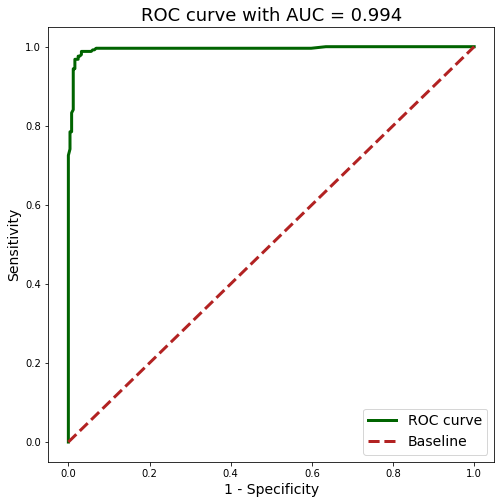

In [162]:
# Plotting the ROC curve to visualize the area under it (AUC).

plt.figure(figsize = (8,8))

# Creating threshold values (plotted as dashed line in plot below).
thresholds = np.linspace(0, 1, 200)

# Defining a function to calculate Sensitivity (True Positive Rate).
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Defining a function to calculate 1 - Specificity (1 - True Negative Rate).
def TNR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculating Sensitivity & 1 - Specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
tnr_values = [TNR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plotting the ROC curve.
plt.plot(tnr_values, tpr_values, label='ROC curve', linewidth=3, color='darkgreen')

# Plotting the baseline, ie. perfect overlap between the two populations.
plt.plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200), label='Baseline', linestyle='--', linewidth=3, color='firebrick')

plt.legend(fontsize=14);

plt.ylabel('Sensitivity', fontsize=14)
plt.xlabel('1 - Specificity', fontsize=14)

plt.title(f'ROC curve with AUC = {round(roc_auc, 3)}', fontsize=18)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/roc_auc_curve.png', bbox_inches='tight');

The above plot shows that the *ROC AUC* value is very close to 1. This implies that **the feature populations (bag of tokens) from the positive class *(r/relationship_advice)* and negative class *(r/legaladvice)* are separated almost perfectly**. And so, this model is a very good classifier for these two subreddits.

### Feature Importance

In [163]:
# Accessing the empirical probabilities of all features (tokens) using the .feature_log_prob_ attribute of MultinomialNB,
# and then calculating its exponential using the np.exp() function.

neg_class_prob = np.exp(mnb_final.feature_log_prob_)[0]
pos_class_prob = np.exp(mnb_final.feature_log_prob_)[1]

neg_class_prob

array([0.00195483, 0.00040033, 0.00131945, 0.00111729, 0.00080441,
       0.00085395, 0.00269996, 0.00057934, 0.00069322, 0.00090533,
       0.00019839, 0.00165781, 0.00075081, 0.00152807, 0.00079216,
       0.00078912, 0.00103424, 0.00176636, 0.0004254 , 0.00039791,
       0.00107024, 0.00197235, 0.00074639, 0.00072094, 0.00053293,
       0.00085768, 0.00206572, 0.00126582, 0.00214024, 0.00044012,
       0.00206677, 0.00077067, 0.00030643, 0.00058206, 0.00067038,
       0.00146635, 0.00050709, 0.00084863, 0.00018761, 0.00141497,
       0.00031071, 0.00033444, 0.00182781, 0.00117224, 0.00026671,
       0.00040576, 0.00115419, 0.0001821 , 0.00343506, 0.00061418,
       0.00090746, 0.00307462, 0.00048087, 0.00076895, 0.00169207,
       0.00142845, 0.00039648, 0.00125146, 0.00097949, 0.00038579,
       0.00015276, 0.00165101, 0.00329221, 0.00022376, 0.00094368,
       0.00048654, 0.00079172, 0.00016172, 0.00151769, 0.00010721,
       0.00073561, 0.00089881, 0.0015478 , 0.00073016, 0.00435

In [164]:
# Sorting the indexes of probabilities from above using the np.argsort() function.
# np.argsort() returns an array of indexes of probabilities from above sorted in an ascending order (feature with lowest probability first).

neg_class_prob_sorted = neg_class_prob.argsort()
pos_class_prob_sorted = pos_class_prob.argsort()

neg_class_prob_sorted

array([ 69, 414, 481, 773, 778, 519, 320, 698, 105, 435, 325, 677, 703,
       476, 268, 362,  60, 197,  67, 493, 265, 345, 393,  47, 833, 305,
       667, 498,  38, 170, 850, 334,  10, 124, 898, 539, 102, 152, 301,
       610, 845,  63, 846, 340, 281, 109, 245, 840, 276, 917, 680,  95,
       179, 364, 754, 216, 390, 211, 499, 196, 514, 180, 725, 100, 852,
        44, 887, 445, 708, 882, 256, 139, 426, 633, 690, 913, 187, 491,
       159, 304, 347, 783, 814,  75, 410, 472, 239, 785, 233, 807, 378,
       369, 104,  32, 408, 248, 550, 772,  40, 168, 636, 933, 405, 929,
       903, 284, 371, 373, 701, 479,  97, 899, 584, 505,  41, 226, 644,
       306, 743, 765, 336,  86, 579, 769, 909, 861,  88, 560, 920, 553,
       289, 506, 328, 721, 847, 424, 580, 398, 603, 554, 533, 277, 595,
       521, 756, 755,  79, 919, 188, 830, 331, 402, 828, 829, 244, 624,
       784, 501,  59, 525, 295, 843, 379, 174, 193, 307,  84, 549, 107,
       623, 135, 634,  90,  56, 212,  19, 150, 541, 561,   1, 74

The 1st element in the array below shows that the feature with the lowest probability is at index 448, the 2nd element in the array below shows that the feature with the second lowest probability is at index 494, and so on. So, **to access the 30 most important features (with highest probabilities), I will have to access the *LAST* 30 elements of this array** (and *NOT* the first 30 elements).

In [165]:
# Accessing the LAST 30 elements from the neg_class_prob_sorted array above.
# As explained above, the numbers in this array below correspond to the indexes of 30 features (tokens) which have the HIGHEST probabilities,
# ie., 30 most important features, in the negative class (r/legaladvice).

neg_class_prob_sorted[::-1][:30]

array([916, 606, 163, 128, 454, 475, 396, 774,  74, 123, 738, 798, 926,
       253, 543, 206, 552, 548, 874, 183, 872, 682, 251,  48, 646, 536,
       669,  62, 450, 537], dtype=int64)

In [166]:
# Getting the corresponding feature (tokens) from the .get_feature_names() method of TfidfVectorizer.

neg_class_top_features = np.take(tfvec_final.get_feature_names(), neg_class_prob_sorted[::-1][:30])
pos_class_top_features = np.take(tfvec_final.get_feature_names(), pos_class_prob_sorted[::-1][:30])

In [167]:
# 30 most important features from positive class (r/relationship_advice).

pos_class_top_features

array(['feel', 'like', 'friend', 'realli', 'talk', 'love', 'thing',
       'think', 'say', 'year', 'togeth', 'boyfriend', 'make', 'want',
       'tri', 'ask', 'girl', 'feel like', 'start', 'tell', 'month',
       'much', 'sex', 'see', 'date', 'back', 'day', 'alway', 'never',
       'guy'], dtype='<U13')

In [168]:
# 30 most important features from positive class (r/legaladvice).

neg_class_top_features

array(['work', 'pay', 'compani', 'car', 'leas', 'live', 'hous', 'state',
       'back', 'call', 'sign', 'take', 'year', 'employ', 'move', 'day',
       'need', 'name', 'use', 'could', 'us', 'rent', 'email', 'anyth',
       'properti', 'money', 'receiv', 'ask', 'law', 'month'], dtype='<U13')

In order to visualize these top features on a graph plot, I need to **filter their corresponding probabilities from the probabilities lists** defined above.

In [169]:
# Getting the corresponding probabilities of top 30 features (tokens) from the neg_class_prob & pos_class_prob arrays defined above.

neg_class_top_features_prob = np.take(neg_class_prob, neg_class_prob_sorted[::-1][:30])
pos_class_top_features_prob = np.take(pos_class_prob, pos_class_prob_sorted[::-1][:30])

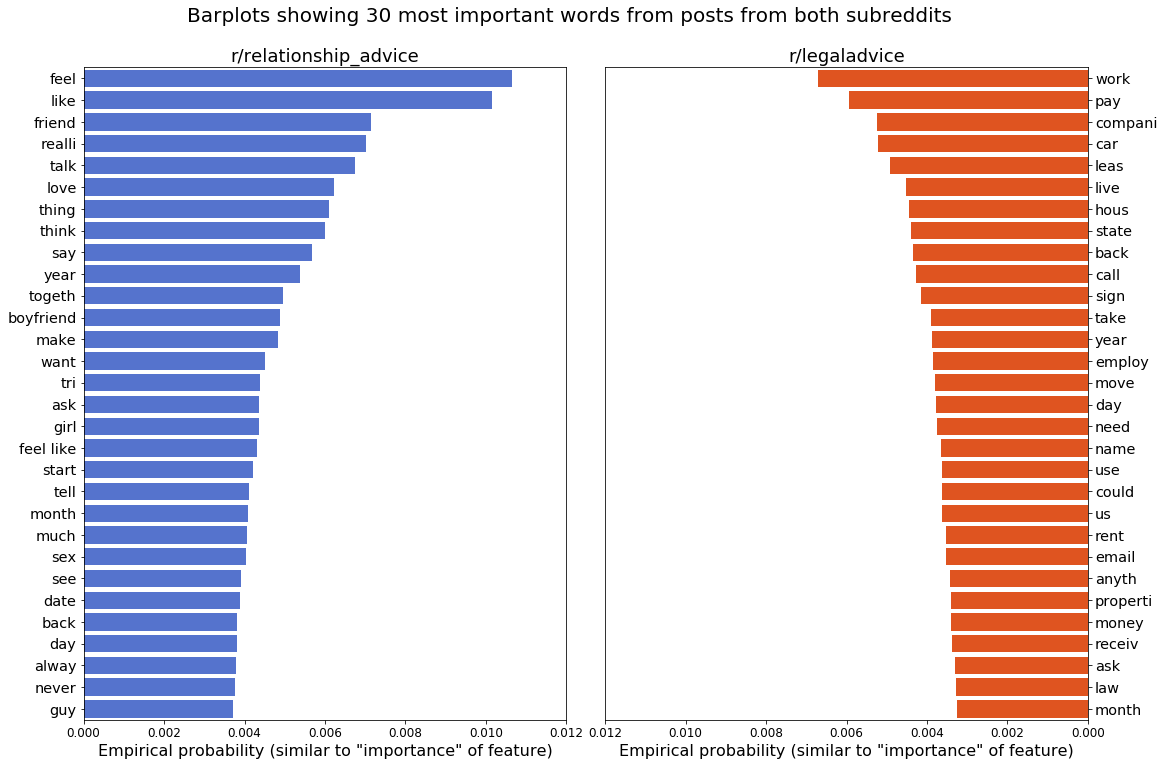

In [170]:
# Plotting barplots to visualise the most important features (tokens) along with their probabilities ("importance").

fig, ax = plt.subplots(figsize=(18,12), ncols=2)

# Reducing space between the two subplots.
plt.subplots_adjust(wspace=0.08)

ax = ax.ravel()

# Plotting horizontal barplots.
sns.barplot(orient='h', y=pos_class_top_features, x=pos_class_top_features_prob, ax=ax[0], color='royalblue')
sns.barplot(orient='h', y=neg_class_top_features, x=neg_class_top_features_prob, ax=ax[1], color='orangered')

# Setting the x-axis limits to be the same on both subplots.
ax[0].set(xlim=(0, round(pos_class_top_features_prob[0]*1.1, 3)))
ax[1].set(xlim=(0, round(pos_class_top_features_prob[0]*1.1, 3)))

# Inverting the x-axis and moving the y-axis labels to the right for subplot on the right.
ax[1].invert_xaxis()
ax[1].yaxis.tick_right()

# Setting the size of axis ticks.
ax[0].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=14.5)
ax[1].tick_params(axis='y', labelsize=14.5)


ax[0].set_xlabel("Empirical probability (similar to \"importance\" of feature)", fontsize=16)
ax[1].set_xlabel("Empirical probability (similar to \"importance\" of feature)", fontsize=16)

ax[0].set_title('r/relationship_advice', fontsize=18)
ax[1].set_title('r/legaladvice', fontsize=18)

fig.suptitle(x=0.5, y=0.95, t="Barplots showing 30 most important words from posts from both subreddits", fontsize=20)

# Exporting plot image in PNG format.
plt.savefig('../plot_images/barplot_most_important_words.png', bbox_inches='tight');

### Evaluation Metrics Summary

In [171]:
# Summarizing all above results.

print("Summary of final model (MultinomialNB with TfidfVectorizer):")
print(f"Training set accuracy \t\t\t= {round(mnb_final.score(X_train_tfvec, y_train)*100, 1)}%")
print(f"Estimated test set accuracy (cv=5) \t= {round(cross_val_score(mnb_final, X_train_tfvec, y_train, cv=5).mean()*100, 1)}%")
print(f"Actual test set accuracy \t\t= {round(mnb_final.score(X_test_tfvec, y_test)*100, 1)}%")
print(f"Sensitivity (True Positive Rate) \t= {round(sensitivity*100, 1)}%")
print(f"Specificity (True Negitive Rate) \t= {round(specificity*100, 1)}%")
print(f"ROC AUC \t\t\t\t= {round(roc_auc, 3)}")
print(f"Total Misclassified Posts \t\t= {fp+fn} out of 500")
conf_mat

Summary of final model (MultinomialNB with TfidfVectorizer):
Training set accuracy 			= 97.5%
Estimated test set accuracy (cv=5) 	= 96.6%
Actual test set accuracy 		= 97.2%
Sensitivity (True Positive Rate) 	= 98.8%
Specificity (True Negitive Rate) 	= 95.6%
ROC AUC 				= 0.994
Total Misclassified Posts 		= 14 out of 500


,Actual r/relationship_advice,Actual r/legaladvice
Predicted r/relationship_advice,248 (True Pos),11 (False Pos)
Predicted r/legaladvice,3 (False Neg),238 (True Neg)


It is seen from above that **the *MultinomialNB* model with *TfidfVectorizer* has a very high classification accuracy on the testing corpus**. However, it also have a **very slight overfit on the training corpus**.

Looking at the *ROC AUC*, the value is very close to 1. This implies that **the feature populations (bag of tokens) from the positive class *(r/relationship_advice)* and negative class *(r/legaladvice)* are separated almost perfectly**. And so, this model is a very good classifier for these two subreddits.

Looking at the *Sensitivity* and *Specificity*, and the numbers of false positives and false negatives, it is also seen that **a lot more posts from *r/legaladvice* got misclassified as being from *r/relationship_advice*, than the other way around**.

So, it can be said that the **classification model has a slight skewness towards the positive class *(r/relationship_advice)***. One of the reasons for this could be the fact that the **posts from *r/relationship_advice* were, on average, much longer than the posts from *r/legaladvice*** (as seen during the EDA process, graph shown below again) - 368 words/post (avg.) in *r/relationship_advice* as compared to 220 words/post (avg.) in *r/legaladvice*. This means that in general, the documents from *r/relationship_advice* contributed more tokens to the model as compared to documents from *r/legaladvice*. And this may have resulted in the classification model being slightly skewed towards *r/relationship_advice*.

![](../plot_images/scatterplot_words_per_post.png)

### Analysis of Misclassified Posts

In [172]:
# Looking at the combined_df dataframe from above.

combined_df.head()

,subreddit,name,title,selftext,num_comments,created_utc,cumulative_posts,created_norm,all_text,post_length,all_text_cleaned,target
0,relationship_advice,t3_gg5aci,"Neighbors leave dog outside 24/7, and the bark...","Moved into a new community over a year ago, qu...",24,2020-05-09 08:33:47,150,10213.0,"Neighbors leave dog outside 24/7, and the bark...",190,neighbor leav dog outsid bark becom unbear mov...,1
1,legaladvice,t3_gflau3,What is up with these harrasing text messages?,I'm getting these phishing text messages. They...,2,2020-05-08 11:12:45,289,33526.0,What is up with these harrasing text messages?...,70,harras text messag get phish text messag say s...,0
2,legaladvice,t3_gge7p9,Is this harassment?,I live in New Mexico. My company hired ny est...,1,2020-05-09 19:56:41,916,151362.0,Is this harassment? I live in New Mexico. My ...,76,harass live new mexico compani hire ny estrang...,0
3,legaladvice,t3_gfk5m8,[AB Canada] I ordered a legal gun that became ...,"Hey Reddit, I currently live in Alberta. On Ap...",0,2020-05-08 09:56:47,244,28968.0,[AB Canada] I ordered a legal gun that became ...,311,ab canada order gun becam prohibit ship licens...,0
4,relationship_advice,t3_gg6tvz,I simply don’t want to even argue anymore,My boyfriend (23M) is great. I (23F) love him ...,4,2020-05-09 10:13:36,244,16202.0,I simply don’t want to even argue anymore My b...,222,simpli argu anymor boyfriend great f love both...,1


In [173]:
# Filtering the indexes and actual target classes of the misclassified posts.

y_test[y_test!=y_pred]

1186    0
1279    0
365     1
44      1
1138    0
1121    0
742     0
358     0
1578    0
916     0
1171    0
1024    0
831     0
1782    1
Name: target, dtype: int64

In [174]:
# Filtering the predictions of the misclassified posts

y_pred[y_test!=y_pred]

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [175]:
# Filtering combined_df to look at only the misclassified posts.

misclassified_df = combined_df.loc[y_test[y_test!=y_pred].index, ['title', 'selftext', 'all_text_cleaned', 'subreddit']]
misclassified_df

,title,selftext,all_text_cleaned,subreddit
1186,overbearing divorced father,my father has had a past of drug and alcohol a...,overbear divorc father father past drug alcoho...,legaladvice
1279,"Scared, paranoid of sexting mistake",I’ll keep this short. It’s not a scam.\n\nA fe...,scare paranoid sext mistak keep short scam mon...,legaladvice
365,Lease?,Do we both put our names on the lease when ren...,leas put name leas rent apart decid safest way...,relationship_advice
44,"I want to move out, here’s why, but my questio...","So disclaimer, this is my first post on reddit...",move question disclaim first post reddit entir...,relationship_advice
1138,"A close friend is in juvie, how do I find what...",Long story short lil homie knocked up a dude. ...,close friend juvi find juvi talk long stori sh...,legaladvice
1121,How can I use a late rapper's beats?,Rapper XXXTENTACION saved my life through musi...,use late rapper beat rapper xxxtentacion save ...,legaladvice
742,Noise complaints,"Hey everyone!,\nCurrently having a neighbor is...",nois complaint hey everyon current neighbor is...,legaladvice
358,NDA was a lie,If the NDA I signed was based on lies is it va...,nda lie nda sign base lie valid like talk trut...,legaladvice
1578,Mortgage with ex,Hi me and my now ex bought a house last year (...,mortgag ex hi ex bought hous last year august ...,legaladvice
916,What about Parents Rights?,What rights do Oregon parents have when their ...,parent right right oregon parent yr old daught...,legaladvice


In [176]:
# Adding columns of actual and predicted y values into the misclassified_df dataframe.

misclassified_df['y_test'] = y_test[y_test!=y_pred]
misclassified_df['y_pred'] = y_pred[y_test!=y_pred]

In [177]:
misclassified_df

,title,selftext,all_text_cleaned,subreddit,y_test,y_pred
1186,overbearing divorced father,my father has had a past of drug and alcohol a...,overbear divorc father father past drug alcoho...,legaladvice,0,1
1279,"Scared, paranoid of sexting mistake",I’ll keep this short. It’s not a scam.\n\nA fe...,scare paranoid sext mistak keep short scam mon...,legaladvice,0,1
365,Lease?,Do we both put our names on the lease when ren...,leas put name leas rent apart decid safest way...,relationship_advice,1,0
44,"I want to move out, here’s why, but my questio...","So disclaimer, this is my first post on reddit...",move question disclaim first post reddit entir...,relationship_advice,1,0
1138,"A close friend is in juvie, how do I find what...",Long story short lil homie knocked up a dude. ...,close friend juvi find juvi talk long stori sh...,legaladvice,0,1
1121,How can I use a late rapper's beats?,Rapper XXXTENTACION saved my life through musi...,use late rapper beat rapper xxxtentacion save ...,legaladvice,0,1
742,Noise complaints,"Hey everyone!,\nCurrently having a neighbor is...",nois complaint hey everyon current neighbor is...,legaladvice,0,1
358,NDA was a lie,If the NDA I signed was based on lies is it va...,nda lie nda sign base lie valid like talk trut...,legaladvice,0,1
1578,Mortgage with ex,Hi me and my now ex bought a house last year (...,mortgag ex hi ex bought hous last year august ...,legaladvice,0,1
916,What about Parents Rights?,What rights do Oregon parents have when their ...,parent right right oregon parent yr old daught...,legaladvice,0,1


In [178]:
# Filtering first misclassified post from r/relationship_advice and printing its title and selftext.

# Using try except loop to avoid raising an error in case there are no misclassified posts from r/relationship_advice.
try:
    pos_class_mis_title = misclassified_df[misclassified_df['y_test']==1].iloc[0]['title']
    pos_class_mis_selftext = misclassified_df[misclassified_df['y_test']==1].iloc[0]['selftext']
    pos_class_mis_all_text = misclassified_df[misclassified_df['y_test']==1].iloc[0]['all_text_cleaned']
    
    print(f"1 of {fn} misclassified posts from r/relationship_advice.")
    print("\n[POST TITLE]")
    print(pos_class_mis_title)
    print("\n[POST SELFTEXT]")
    print(pos_class_mis_selftext)

except:
    print("No misclassified posts from r/relationship_advice.")

1 of 3 misclassified posts from r/relationship_advice.

[POST TITLE]
Lease?

[POST SELFTEXT]
Do we both put our names on the lease when renting an apartment? How do you decide what's the safest way in case anything happens?


In [179]:
# Comparing all words in the above misclassified post from r/relationship_advice against the 30 most important words in r/legaladvice.
mis_pos_against_neg_top = [word for word in neg_class_top_features if word in pos_class_mis_all_text]

# Comparing all words in the above misclassified post from r/relationship_advice against the 30 most important words in the same subreddit.
mis_pos_against_pos_top = [word for word in pos_class_top_features if word in pos_class_mis_all_text]

In [180]:
# Summarising above filtered words.

# Using try except loop to avoid raising an error in case there are no misclassified posts from r/relationship_advice.
try:
    print(f"1 of {fn} misclassified posts from r/relationship_advice.")
    print("\nFollowing words from 30 most important words from r/legaladvice exist in this post:")
    print(mis_pos_against_neg_top)
    print("\nFollowing words from 30 most important words from r/relationship_advice exist in this post:")
    print(mis_pos_against_pos_top)

except:
    print("No misclassified posts from r/relationship_advice.")

1 of 3 misclassified posts from r/relationship_advice.

Following words from 30 most important words from r/legaladvice exist in this post:
['leas', 'name', 'rent', 'anyth']

Following words from 30 most important words from r/relationship_advice exist in this post:
[]


In [181]:
# Filtering first misclassified post from r/legaladvice and printing its title and selftext.

# Using try except loop to avoid raising an error in case there are no misclassified posts from r/legaladvice.
try:
    neg_class_mis_title = misclassified_df[misclassified_df['y_test']==0].iloc[0]['title']
    neg_class_mis_selftext = misclassified_df[misclassified_df['y_test']==0].iloc[0]['selftext']
    neg_class_mis_all_text = misclassified_df[misclassified_df['y_test']==0].iloc[0]['all_text_cleaned']
    
    print(f"1 of {fp} misclassified posts from r/legaladvice.")
    print("\n[POST TITLE]")
    print(neg_class_mis_title)
    print("\n[POST SELFTEXT]")
    print(neg_class_mis_selftext)

except:
    print("No misclassified posts from r/legaladvice.")

1 of 11 misclassified posts from r/legaladvice.

[POST TITLE]
overbearing divorced father

[POST SELFTEXT]
my father has had a past of drug and alcohol abuse and has never really been much of a stable father. he was a dick to my mom until they divorced then he still continued to use her physically. me and my brother have always kind of been scared of him. last year cps did come to our house and nothing changed. they gave him every other day alcohol tests but after they were over he just went back to it. i never expected much to change because my situation wasn't as bad. but this year has kind of escalated. he never got too physical but he might. also if i were to get involved with cps again either nothing would change again or i would live with my mom but i do not want to move. i love my house and my neighborhood, my mom lives about 45 mins away and she doesn't have a lot of money. she most likely cant support two kids and a dog. i'm very worried as to what would happen to my dog if i 

In [182]:
# Comparing all words in the above misclassified post from r/legaladvice to the 30 most important words in r/relationship_advice.
mis_neg_against_pos_top = [word for word in pos_class_top_features if word in neg_class_mis_all_text]

# Comparing all words in the above misclassified post from r/legaladvice to the 30 most important words in the same subreddit.
mis_neg_against_neg_top = [word for word in neg_class_top_features if word in neg_class_mis_all_text]

In [183]:
# Summarising above filtered words.

# Using try except loop to avoid raising an error in case there are no misclassified posts from r/legaladvice.
try:
    print(f"1 of {fp} misclassified posts from r/legaladvice.")
    print("\nFollowing words from 30 most important words from r/relationship_advice exist in this post:")
    print(mis_neg_against_pos_top)
    print("\nFollowing words from 30 most important words from r/legaladvice exist in this post:")
    print(mis_neg_against_neg_top)

except:
    print("No misclassified posts from r/legaladvice.")

1 of 11 misclassified posts from r/legaladvice.

Following words from 30 most important words from r/relationship_advice exist in this post:
['like', 'realli', 'love', 'year', 'tell', 'much', 'back', 'day', 'alway', 'never']

Following words from 30 most important words from r/legaladvice exist in this post:
['car', 'live', 'hous', 'back', 'call', 'year', 'move', 'day', 'use', 'could', 'us', 'money']


## Conclusions and Recommendations

Beginning with the problem statement of automatically categorizing the posts seeking advice on different subreddits, this project started with scraping a thousand posts each from two subreddits - *r/relationship_advice* and *r/legaladvice* - via the Reddit API. The posts were then verified, cleaned and pre-processed for EDA and classification modelling later on.

The next step of the process was EDA, which highlighted the significant differences in the levels of user activity between the two subreddits. Even though both the subreddits were created only months apart in 2009, *r/relationship_advice* has grown tremendously since then and currently has more than 3 million subscribers. In contrast, *r/legaladvice* currently only has about 1.2 million subscribers. The EDA process also showed that people in general comment more than twice as much on *r/relationship_advice* than on *r/legaladvice*. Furthermore, the posts on *r/relationship_advice* are generally much longer (avg. 368 words per post) than those on *r/legaladvice* (avg. 220 words per post). This EDA process gave an initial indication of the possibility that the classification model may be skewed towards *r/relationship_advice* because of the larger amount of word tokens being fed into the classification model from this subreddit. The EDA process, through wordclouds, also showed the similarities and differences in the words used in posts from both subreddits.

Following the EDA process, different classification models were built and evaluated using the *accuracy* metric. A final model *(MultinomialNB with TfidfVectorizer)* was then chosen, and built again on the entire training corpus for further evaluation using metrics such as *sensitivity (true positive rate), specificity (true negative rate) and ROC AUC*. The important features (word tokens) in both subreddits were also visualized, along with a brief analysis of the misclassified posts.

The following is a summary of the classification models and their evaluation metrics.

In [184]:
summary_df

,trans_est,GSCV_best_params,GSCV_best_score,train_accuracy,test_accuracy
1,"CountVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngr...",0.938,0.998,0.930
2,"TfidfVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngr...",0.956,0.979,0.960
3,"TfidfVec, KNN","n_neighbors=7, p=2, max_features=500, ngram_ra...",0.911,1.000,0.912
4,"TfidfVec, MulNB","alpha=0.5, max_features=1000, min_df=0.02, max...",0.969,0.977,0.974
5,"TfidfVec, RandomForestClassifier","max_depth=7, n_estimators=100, max_features=2000",0.927,0.960,0.920


In [185]:
# Printing summary of final model (MultinomianlNB with TfidfVectorizer).

print("Summary of final model (MultinomialNB with TfidfVectorizer):")
print(f"Training set accuracy \t\t\t= {round(mnb_final.score(X_train_tfvec, y_train)*100, 1)}%")
print(f"Estimated test set accuracy (cv=5) \t= {round(cross_val_score(mnb_final, X_train_tfvec, y_train, cv=5).mean()*100, 1)}%")
print(f"Actual test set accuracy \t\t= {round(mnb_final.score(X_test_tfvec, y_test)*100, 1)}%")
print(f"Sensitivity (True Positive Rate) \t= {round(sensitivity*100, 1)}%")
print(f"Specificity (True Negitive Rate) \t= {round(specificity*100, 1)}%")
print(f"ROC AUC \t\t\t\t= {round(roc_auc, 3)}")
print(f"Total Misclassified Posts \t\t= {fp+fn} out of 500")
conf_mat

Summary of final model (MultinomialNB with TfidfVectorizer):
Training set accuracy 			= 97.5%
Estimated test set accuracy (cv=5) 	= 96.6%
Actual test set accuracy 		= 97.2%
Sensitivity (True Positive Rate) 	= 98.8%
Specificity (True Negitive Rate) 	= 95.6%
ROC AUC 				= 0.994
Total Misclassified Posts 		= 14 out of 500


,Actual r/relationship_advice,Actual r/legaladvice
Predicted r/relationship_advice,248 (True Pos),11 (False Pos)
Predicted r/legaladvice,3 (False Neg),238 (True Neg)


It was observed from the evaluation metrics that **the *MultinomialNB* model with *TfidfVectorizer* has a very high classification accuracy on the testing corpus**. It was also seen that the value of accuracy calculated while training the model on k-folds of cross validation *(estimated test set accuracy)* was quite similar to when the model was used to classify the posts from the test dataset *(actual test set accuracy)*, with only a slight increase or decrease. This implies that **this classification model would mostly generalize well on new unseen data**.

The *ROC AUC* value is also very close to 1, implying that **the feature populations (bag of tokens) from the positive class *(r/relationship_advice)* and negative class *(r/legaladvice)* are separated almost perfectly**. And so, this model is a very good classifier for these two subreddits.

Looking at the *Sensitivity* and *Specificity*, and the numbers of false positives and false negatives, it is also seen that **a lot more posts from *r/legaladvice* got misclassified as being from *r/relationship_advice*, than the other way around**. So, it can be said that the **classification model has a slight skewness towards the positive class *(r/relationship_advice)***. One of the reasons for this could be the fact that the **posts from *r/relationship_advice* were, on average, much longer than the posts from *r/legaladvice*** (as seen during the EDA process) - 368 words/post (avg.) in *r/relationship_advice* as compared to 220 words/post (avg.) in *r/legaladvice*. This means that in general, the documents from *r/relationship_advice* contributed more tokens to the model as compared to documents from *r/legaladvice*. And this may have resulted in the classification model being slightly skewed towards *r/relationship_advice*.

So, to answer the problem statement, **it is indeed possible to automatically categorize posts seeking advice into different categories/subreddits**. This feature, if implemented, should help to better guide users seeking advice to the appropriate subreddits, so that their requests can be answered in a better and effective manner by the dedicated subreddit community. **In the case of the two subreddits chosen here - *r/relationship_advice* and *r/legaladvice*, it can be said that the posts can be classified with a very high degree of accuracy, which would imply that the automatic suggestions of subreddits given to the users based on their posts would be very appropriate and helpful.**

**However, this may not always be the case, especially if some subreddits are closely related to each other in terms of the topics being discussed in them.** Further in-depth studies could be carried out with combinations of different subreddits dedicated to advice seeking to see how well they can be classified. This would help to improve the suggestions feature even further.